In [1]:
%reset -f 
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pickle
import random
from datetime import datetime
from pathlib import Path
from scipy.signal import savgol_filter
from scipy.stats import zscore, median_abs_deviation
import pyarrow.parquet as pq 
import matplotlib.pyplot as plt
from itertools import groupby

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):   # cells can be skipped by using '%%skip' in the first line
    return

In [2]:
# ------------ LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  --------------
import sys, os; from pathlib import Path                                                #|
global ROOT, DATA_PATH, IS_NOTEBOOK; IS_NOTEBOOK = True                                 #|
ROOT = Path('..').resolve() if IS_NOTEBOOK else Path('.').resolve()                     #|
print(f"{'-'*60}\n{ROOT}:\t{', '.join([_.name for _ in ROOT.glob('*/')])}")             #|
sys.path.append(os.path.abspath(ROOT))                                                  #|
from data import get_data_path  # paths set in "data/__init__.py"                       #|
DATA_PATH = get_data_path()                                                             #|
print(f"{DATA_PATH}:\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}")           #|
# ----------------------------------------------------------------------------------------

------------------------------------------------------------
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN:	.git, archive, data, project, ref, src, test
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data:		ext, final, final_2, processed, trips_processed_final, trips_processed_pickles, trips_processed_resampled, y_true


In [3]:
# relative Imports: ---------------------------------------------------------------------------------------------------
from src.physics_model.VehModel import CreateVehicle

# FILE SOURCES ---------------------------------------------------------------
original_trips_folder = Path(DATA_PATH, "processed") # original Trip parquet files
all_trips_folder = Path(DATA_PATH, "ext", "new_sequences") # new trip sequences (not preprocessed)

# OUTPUT LOCATIONS ---------------------------------------------------------------
trips_processed_final = Path(DATA_PATH, "ext", "trips_processed_final") # Trip parquet files
trips_processed_resampled = Path(DATA_PATH, "ext", "trips_processed_resampled") # Trip parquet filesn for resampled time series
trips_processed_pickles = Path(DATA_PATH, "ext", "trips_processed_pickles") # Trip parquet files

In [4]:
# GET DIRECTORY CONTENS:
def get_files(folder, ext, full = False): return [file if full else file.name for file in folder.glob(f'*{ext}')]
trips = get_files(all_trips_folder, ".parquet", full = False)
original_trips = get_files(original_trips_folder, ".parquet", full = False)
len(trips)

16903

In [5]:
# get list of signals
df = pd.read_parquet(Path(all_trips_folder, trips[0]), engine='fastparquet')
all_columns = df.columns
assert len(all_columns) == 114

In [6]:
# first scan of trips to identify sparse signals and trips that do not meet the requirements
def first_scan(trips, all_columns):
    sparse_signals = set(all_columns)  # Start with all columns
    short_trips = []               # collect all trips shorter than limit of 1 km

    for n,f  in enumerate(trips):
        df = pd.read_parquet(Path(all_trips_folder, f), engine='fastparquet')

        current_sparse = set(df.columns[df.isna().mean() > 0.9])
        sparse_signals &= current_sparse  # Keep only columns that are sparse in all dataframes

        dist = df["hirestotalvehdist_cval_icuc"]
        if dist.last_valid_index() is not None and dist.first_valid_index() is not None:
            d_dist = dist[dist.last_valid_index()] - dist[dist.first_valid_index()]
        else:
            d_dist = dist.iloc[-1] - dist.iloc[0]
        if d_dist < 0.2: 
            print(f"less than 0.2 km: {f}, {n}")
            short_trips.append(f)

    return sparse_signals, short_trips

# sparse_signals, short_trips = first_scan(trips, all_columns)

In [7]:
# SUMMARY OF ANALYSIS: 
#############################################################################################################################################
# SIGNALS  ###################################################################################################
# these signals always have more than 90% nans and will be removed from all trips:
sparse_signals = {'odometer','signal_date','vehicle_id', 'diff',
                  'chrgcoupproxydet_stat','hv_batmaxdischrgpwrlim_cval', 'hv_ptc2_pwr_cval',
                  'inv1_curr_cval_api1','inv1_pwr_cval_api1','inv1_pwr_cval_api3','inv1_spd_cval_api1','inv2_curr_cval_api2','inv2_pwr_cval_api2', 'inv2_spd_cval_api2'}

# these signals are either all-nans in a significant amount of trips or are too redundant/insignificant and will thus be removed from all trips:
remove_signals = {"minmoduletempindex_bms01", "maxmoduletempindex_bms01", "brc_stat_brc2", "maxpwr_contendrnbrkresist2","currtmp_brkresist2int_cval", "currpwr_contendrnbrkresist2",
                  "plugchrg_stat", "hv_chrgpwr_ecpc_cval", "chargestate", "dsrdpwr_contendrn_cval", "dsrdpwr_contendrn2_cval","maproadgrad_cval", "airtempoutsd_cval_sca", 
                  "meanmoduletemperature_bms01", "linkvoltage_bms05", "lv_conv_voltdmd_e2e_dcl1", "lv_convmaxcurr_cval_dcl1", "lv_convcurr_cval_dcl1","lv_conv_dc_momvolt_cval_dcl1", 
                  "hv_batlinkvoltage_sc01", "hv_dclink_volt_cval_brc", "hv_dclink_volt_cval_brc2", "oiltemp_ra_cval","hv_bat_intres_cval_bms1", "stringvoltage_bms01", 
                  "currtmp_brkresist1int_cval", "maxpwr_contendrnbrkresist_cval", "hv_bat_dc_volt_cval_bms1", "pt4_dcb_temp2_st3", "pt4_dcb_temp1_st3", "maxbrickvoltage_bms01"}

# these signals are either identical or too correlated with other signals and will be removed from all trips:
redundant_signals = {'hirestotalvehdist_cval_cpc', 'ambtemp_cval_pt', 'grshift_stat_pt', 'currgr_stat_edcu', 'edrvspd_cval', 'hv_bat_dc_maxvoltlim_cval',
                     'hv_bat_dc_minvoltlim_cval', 'ignsw_stat_sca'}
#     --> also remove: 'hv_batmomavlchrgen_cval_bms1'

# interrelated signal pairs can be combined to only introduce one variable (no status signals):
pair_signals = [('brktempfa_cval', 'brktempra_cval'),  # only the first variable of each pair will be kept
   ('actualdcvoltage_pti1', 'actualdcvoltage_pti2'), 
   ('actualspeed_pti1', 'actualspeed_pti2'), 
   ('actualtorque_pti1','actualtorque_pti2'),
   ('motortemperature_pti1','motortemperature_pti2'),
   ('powerstagetemperature_pti1', 'powerstagetemperature_pti2'),
   ('rmsmotorcurrent_pti1','rmsmotorcurrent_pti2')]

# optional signals
# could be kept and filled with zeros/ones instead, to retain the ePTO feature if available in the truck
optional_or_zero = ['epto_pwr_cval', 'currpwr_contendrnbrkresist_cval', 'elcomp_pwrcons_cval'] # --> fill with: "0" if not available
optional_or_one = ['brc_stat_brc1'] #--> fill with "1" if not available

# FILES  ###################################################################################################
# these trips do not contain valid trips or are sorted out for other reasons
invalid_trips = []
short_trips = ['V101_T267.parquet', 'V101_T287.parquet', 'V101_T300.parquet', 'V101_T484.parquet', 'V101_T78.parquet', 'V10_T204.parquet', 'V10_T227.parquet', 
               'V10_T92.parquet', 'V11_T112.parquet', 'V11_T215.parquet', 'V11_T24.parquet', 'V11_T317.parquet', 'V12_T83.parquet', 'V14_T1430.parquet', 'V14_T1992.parquet', 
               'V14_T1996.parquet', 'V14_T2061.parquet', 'V14_T2127.parquet', 'V15_T275.parquet', 'V16_T1038.parquet', 'V16_T1292.parquet', 'V16_T1334.parquet', 
               'V16_T1401.parquet', 'V16_T1578.parquet', 'V16_T255.parquet', 'V16_T267.parquet', 'V16_T341.parquet', 'V16_T386.parquet', 'V16_T394.parquet', 'V16_T402.parquet', 
               'V16_T451.parquet', 'V16_T541.parquet', 'V16_T547.parquet', 'V16_T559.parquet', 'V16_T566.parquet', 'V16_T593.parquet', 'V16_T859.parquet', 'V16_T880.parquet', 
               'V16_T904.parquet', 'V16_T917.parquet', 'V16_T920.parquet', 'V17_T1284.parquet', 'V17_T1454.parquet', 'V17_T1560.parquet', 'V17_T1571.parquet', 'V17_T1591.parquet', 
               'V17_T2384.parquet', 'V17_T3913.parquet', 'V17_T4949.parquet', 'V17_T5059.parquet', 'V17_T5114.parquet', 'V17_T5339.parquet', 'V17_T715.parquet', 'V17_T852.parquet', 
               'V18_T156.parquet', 'V18_T211.parquet', 'V18_T348.parquet', 'V18_T361.parquet', 'V18_T377.parquet', 'V18_T401.parquet', 'V18_T443.parquet', 'V18_T473.parquet', 
               'V18_T770.parquet', 'V18_T826.parquet', 'V18_T861.parquet', 'V18_T865.parquet', 'V1_T220.parquet', 'V1_T236.parquet', 'V1_T445.parquet', 'V1_T447.parquet', 
               'V2_T223.parquet', 'V4_T169.parquet', 'V4_T253.parquet', 'V4_T373.parquet', 'V4_T474.parquet', 'V4_T483.parquet', 'V4_T492.parquet', 'V4_T614.parquet', 
               'V4_T633.parquet', 'V4_T7.parquet']


In [8]:
# conlusively, these are the trips to be included in the final dataset:
trips = [_ for _ in trips if _ not in short_trips and _ not in invalid_trips]
print('Keep no. trips: ', len(trips))
# these are the signals that will be removed
drop_signals = list(sparse_signals | remove_signals | redundant_signals)
print('Keep no. signals: ', len(all_columns) - len(drop_signals))

Keep no. trips:  16823
Keep no. signals:  61


In [9]:
# these signals should be explicitly considered for outlier removal to clean and improve data quality
signal_remove_outliers = ["latitude_cval_ippc", "longitude_cval_ippc","altitude_cval_ippc","roadgrad_cval_pt", 
"bs_roadincln_cval","hirestotalvehdist_cval_icuc","vehspd_cval_cpc", "hv_batmomavldischrgen_cval_1",
"hv_bat_soc_cval_bms1", "airtempinsd_cval_hvac", "airtempoutsd_cval_cpc", "hv_batavcelltemp_cval_bms1",
"hv_bathighcelltemp_cval_bms1","hv_batlowcelltemp_cval_bms1", "hv_dclink_volt_cval_dcl1", "actualdcvoltage_pti1", "hv_bat_dc_momvolt_cval_bms1",
"hv_batmaxchrgpwrlim_cval_1", "hv_batmaxdischrgpwrlim_cval_1"]

In [10]:
####################################################################################################
def expand_indices(r_list, ws, offset, max_val):
    r_set = set(r_list).copy()
    for i in range(-ws,ws+1):
        r_set = r_set | set([x+i for x in r_list])
    r_set = [x+offset for x in list(r_set)]
    drops = [x for x in list(r_set) if (x>=0 and x<max_val)]
    return sorted(drops)

####################################################################################################   
def smooth_filter(X, ws, remove_outliers = True, smooth = True):

    def custom_filter(X,ws, remove_outliers, thresh = 8):
        X_filtered = X.copy()
        X_noise  = abs(zscore(X.ffill().bfill() - savgol_filter(X.ffill().bfill(), ws,1, mode='nearest'), nan_policy='omit'))
        if remove_outliers:
            cr = X.std() - median_abs_deviation(X, nan_policy='omit')
            thresh_new = max(abs(X.std() / cr), thresh) if cr != 0 else max(abs(X.std()), thresh)
            peaks = expand_indices(list(np.where((X_noise > thresh_new))[0]), int(ws), 0, len(X))
            X_filtered[peaks] = np.nan
            X_filtered[X_noise.isna()] = np.nan
        else:
            thresh_new = None

        if X_filtered.nunique() < 2:
            X_filtered.fillna(X_filtered.mean(), inplace=True)
        else:
            X_filtered.ffill(inplace=True)
            X_filtered.bfill(inplace=True)  

        return X_filtered, X_noise, thresh_new

    X_filtered, X_noise, thresh = custom_filter(X, ws, remove_outliers = remove_outliers)
    
    if (X - X_filtered).std() > 10:
        X_filtered, X_noise, thresh = custom_filter(X_filtered, ws, remove_outliers = remove_outliers)

    if smooth: X_filtered = savgol_filter(X_filtered, ws/2,1, mode='nearest')
    return X_filtered, X_noise, thresh

####################################################################################################
def get_slices(c_state, min_length=60, exp=lambda val: val == 0):
        slices = []
        start = None
        for i, val in enumerate(c_state):
            condition = exp(val)
            if condition and start is None:
                    start = i
            elif not condition and start is not None:
                    if (i - start) >= min_length:
                        slices.append(slice(start, i))
                    start = None
        if start is not None and (len(c_state) - start) >= min_length:
            slices.append(slice(start, len(c_state)))
        return slices

####################################################################################################
def intersect_slices(slices_A, slices_B):
    intersection_slices = []
    for v_slice in slices_A:
        for c_slice in slices_B:
            start = max(v_slice.start, c_slice.start)
            stop = min(v_slice.stop, c_slice.stop)
            if start < stop:
                intersection_slices.append(slice(start, stop))
    return intersection_slices

####################################################################################################
def split_dataframe_by_slices(df, slices):
    return [df.iloc[s] for s in slices]

####################################################################################################
idx_dict = {}
def save_dataframes_to_parquet(dataframes, base_path, idx_dict, veh_id):
    if f"{veh_id}" not in idx_dict: idx_dict[f"{veh_id}"] = 0
    start_idx = idx_dict[f"{veh_id}"]+1
    new_files = []
    for i, df in enumerate(dataframes):
        filename = f"V{veh_id}_T{i+start_idx}.parquet"
        new_files.append(filename)
        df.to_parquet(Path(base_path, filename), engine='fastparquet')
    idx_dict[f"{veh_id}"] = start_idx + i
    return new_files, idx_dict

####################################################################################################
def find_nan_sections(series):
    nan_sections = []
    start_idx = None

    for idx, value in series.isna().items():
        if value and start_idx is None:
            start_idx = idx
        elif not value and start_idx is not None:
            if idx > start_idx + 2:
                nan_sections.append(start_idx)
            start_idx = None

    if start_idx is not None:
        nan_sections.append(start_idx)

    # Remove neighboring numbers
    nan_sections = [nan_sections[i] for i in range(len(nan_sections)) if i == 0 or nan_sections[i] != nan_sections[i-1] + 1]

    return nan_sections

0: v_id983V16_trip101.parquet
	Vehicle ID: 16, File Code: V16_trip101, Prefix: v_id983
Split indices: Index([9901, 9906, 9908, 10049, 10114], dtype='int64')
[slice(567, 937, None), slice(5104, 5279, None), slice(5724, 5769, None), slice(5898, 8394, None), slice(9781, 9840, None), slice(9905, 9906, None), slice(9905, 9908, None), slice(9907, 9918, None), slice(10779, 10940, None), slice(11258, 11358, None), slice(11635, 13872, None), slice(14748, 15083, None), slice(15860, 16208, None), slice(16731, 17309, None)]
0.32432432432432434
0.17714285714285713
0.09455128205128205
0.37888198757763975
0.014751899865891819
		Section 0 from 567 to 937, length: 370, mean speed: 8.77
		Section 1 from 5104 to 5279, length: 175, mean speed: 11.38
		Section 2 from 5898 to 8394, length: 2496, mean speed: 47.35
		Section 3 from 10779 to 10940, length: 161, mean speed: 12.04
		Section 4 from 11635 to 13872, length: 2237, mean speed: 54.93


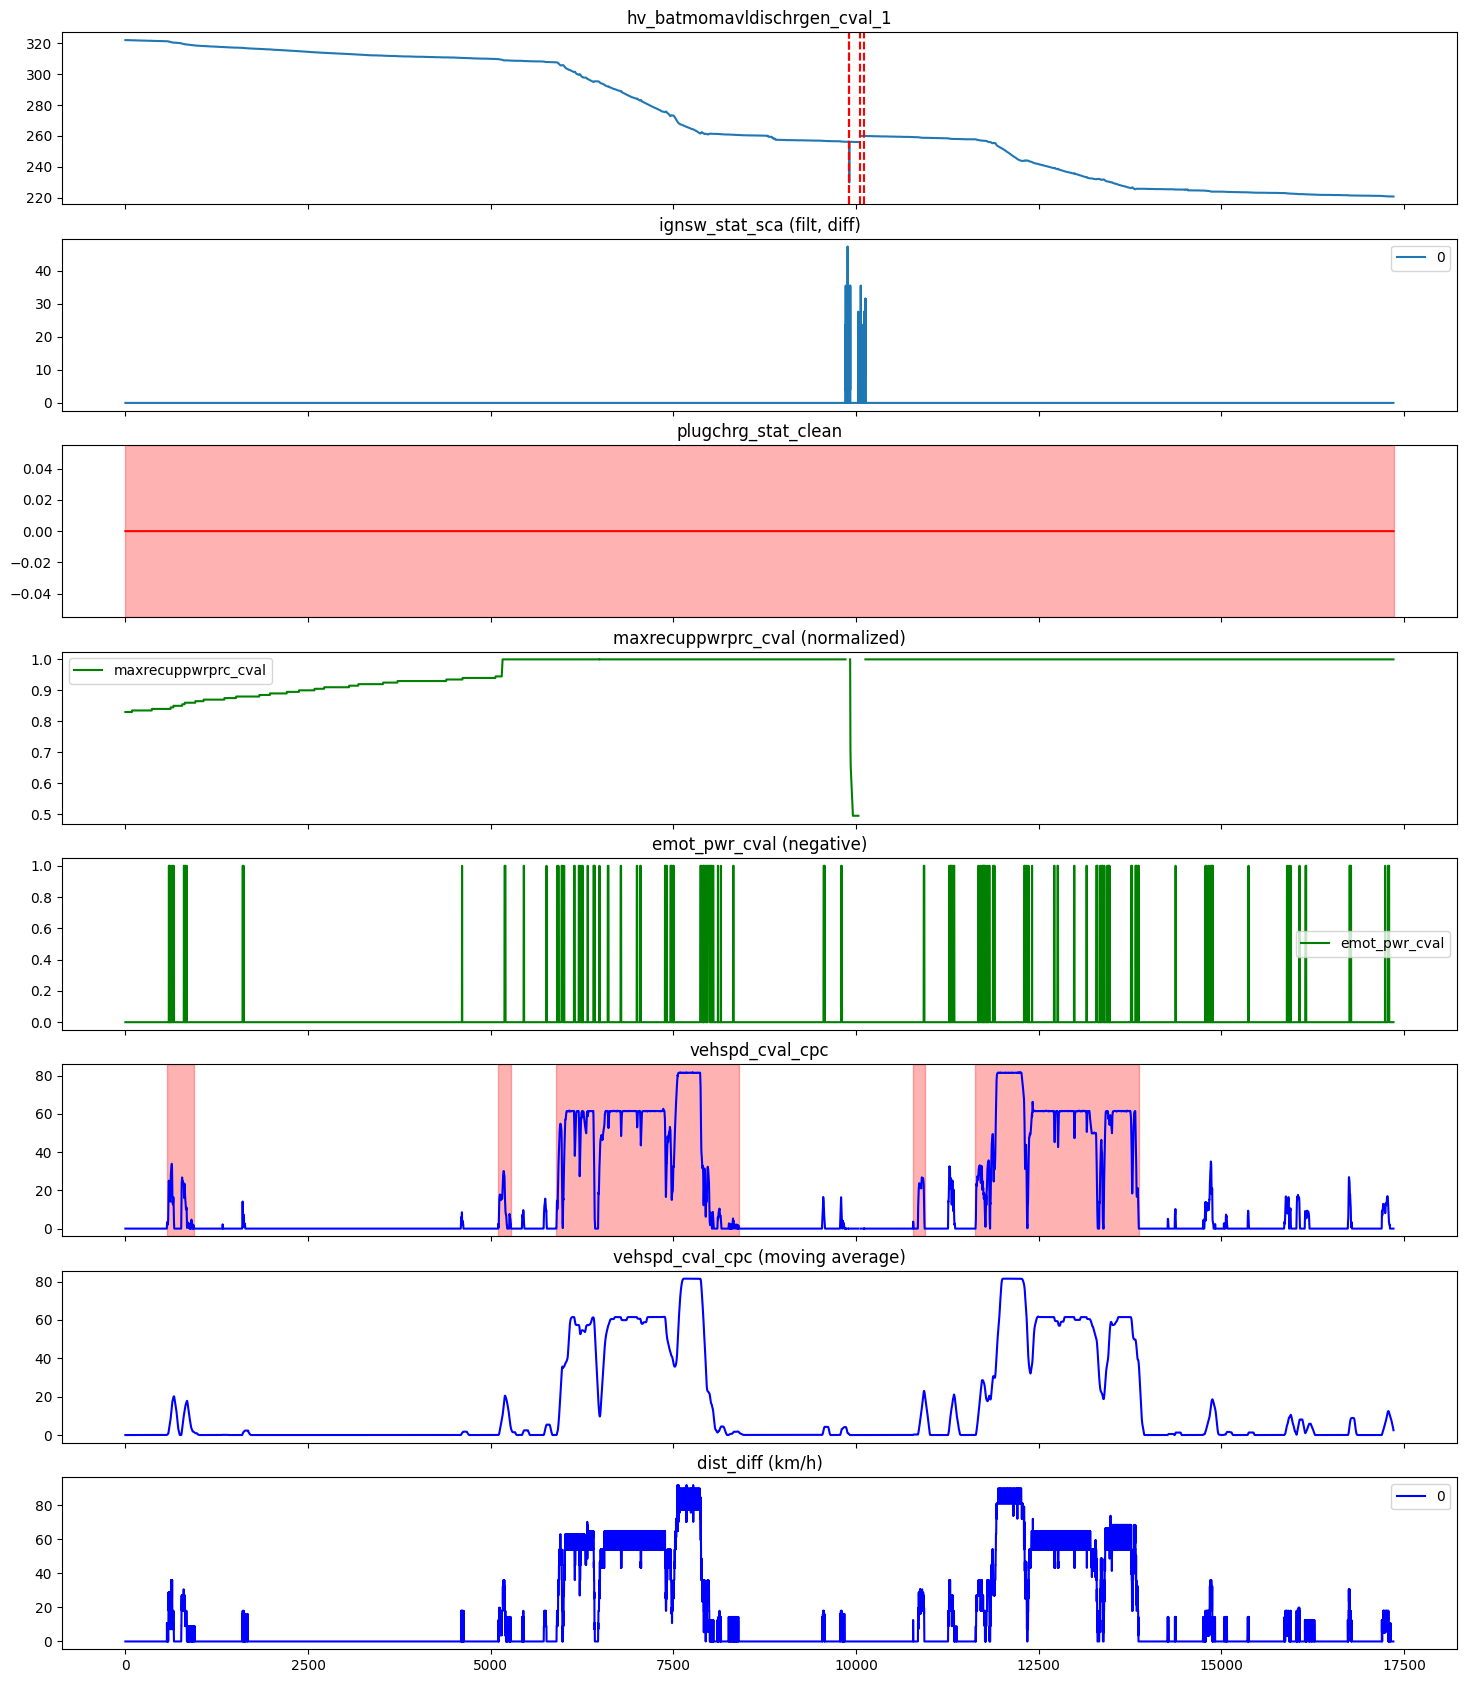

section: slice(567, 937, None)
370
(0.0, 0.0)


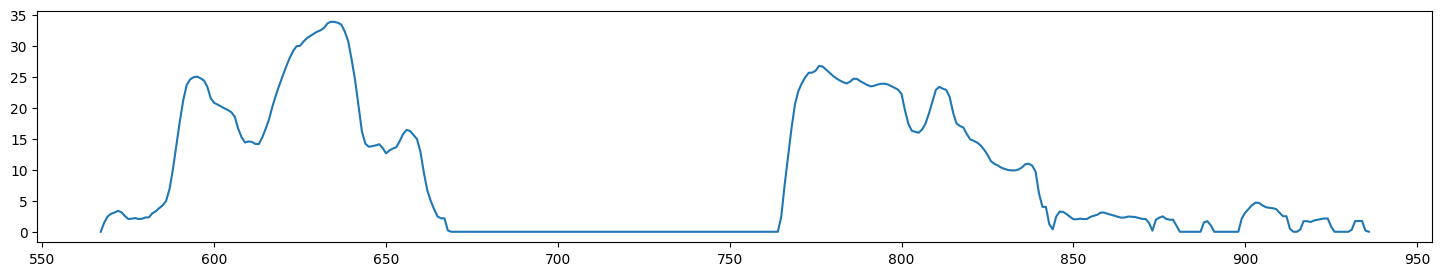

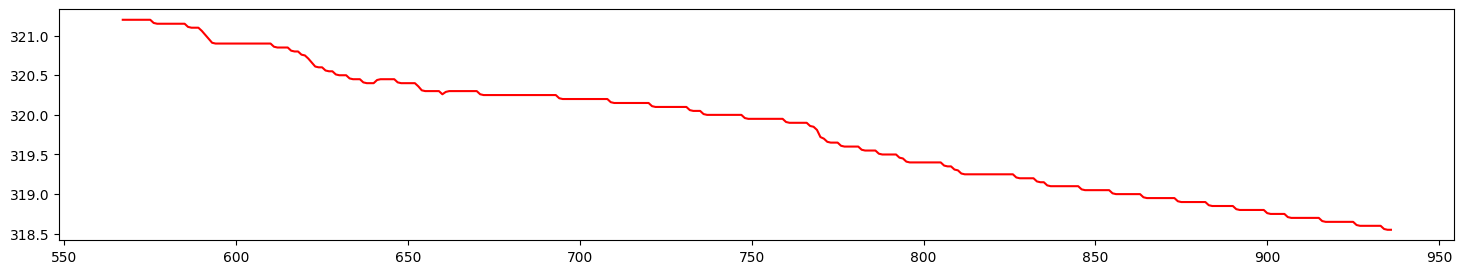

section: slice(5104, 5279, None)
175
(0.0, 0.0)


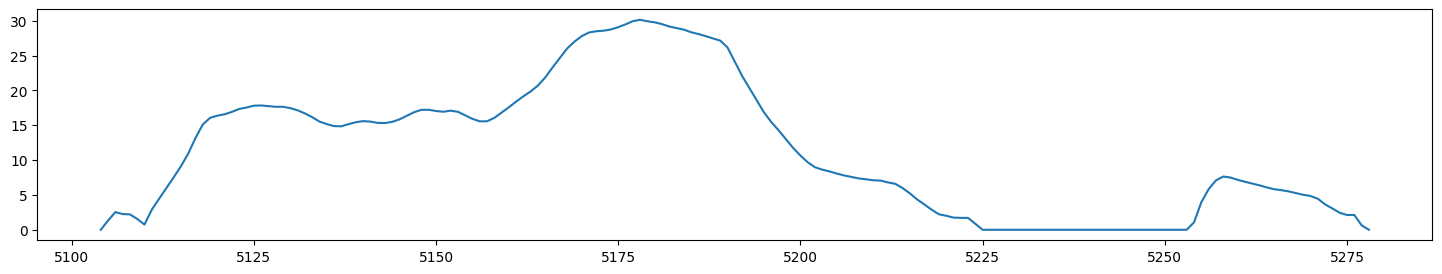

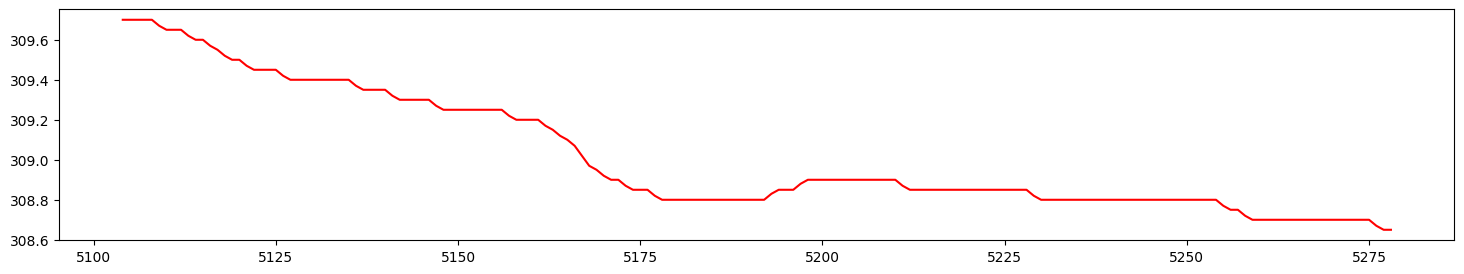

section: slice(5898, 8394, None)
2496
(0.0, 0.0)


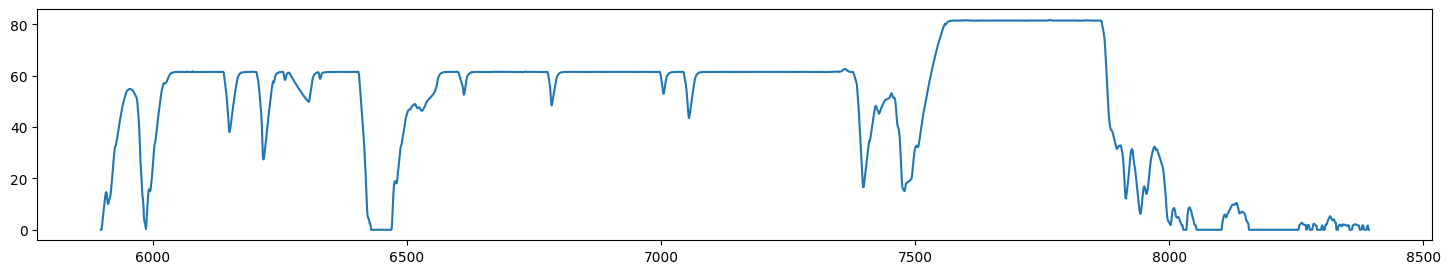

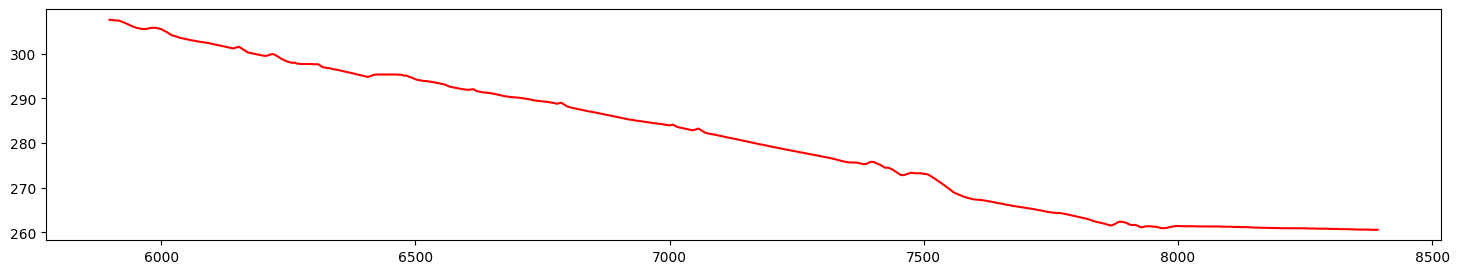

section: slice(10779, 10940, None)
161
(0.0, 0.0)


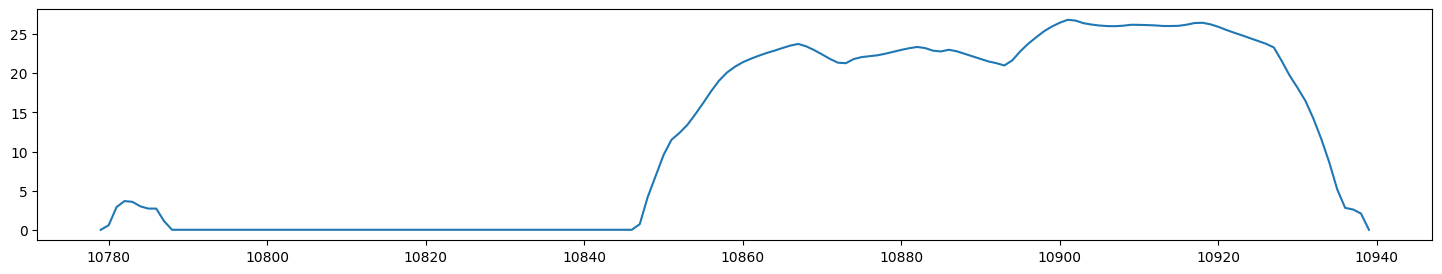

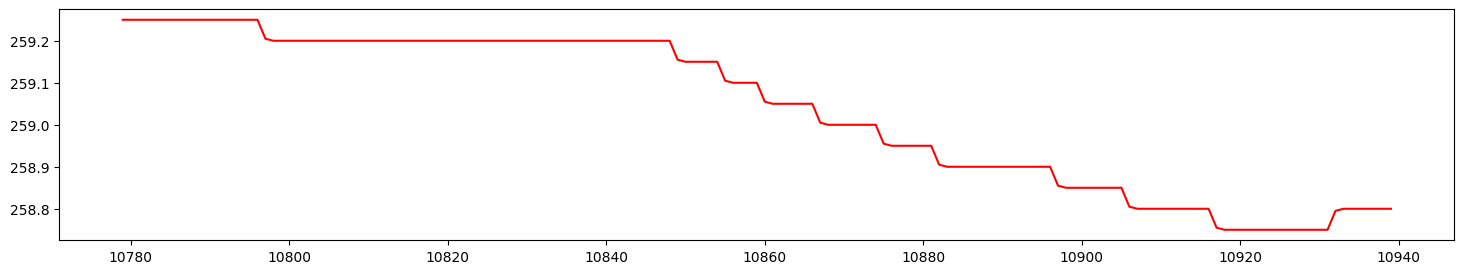

section: slice(11635, 13872, None)
2237
(0.0, 0.0)


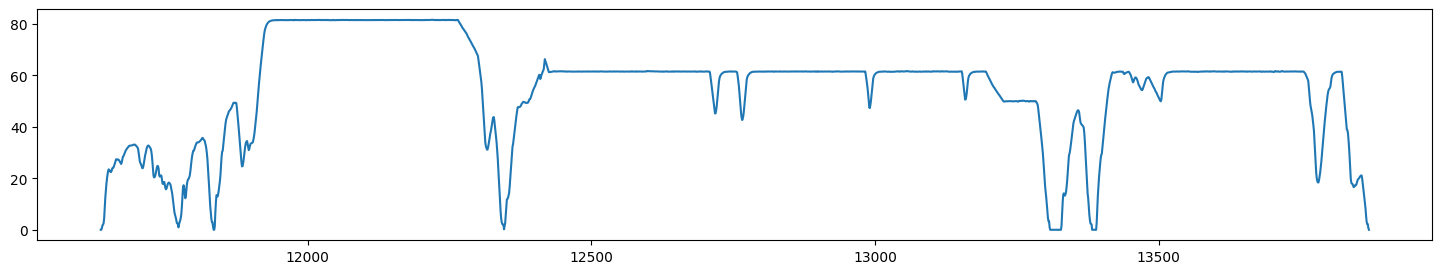

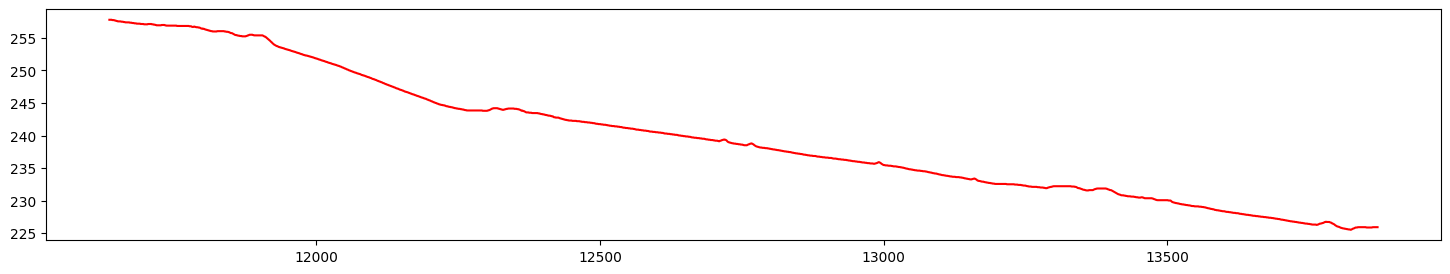

In [109]:
#%%skip
for n, f in enumerate(random.sample(original_trips, 1)):
    #f = 'v_id983V16_trip178.parquet'
    print(f"{n}: {f}"); vehicle_id = f[8:11].strip("_t"); file_code = f[7:-8]; prefix = f[:7]
    print(f"\tVehicle ID: {vehicle_id}, File Code: {file_code}, Prefix: {prefix}")

    df = pd.read_parquet(Path(original_trips_folder, f), engine='fastparquet')
    df.sort_index(axis=1, inplace=True)
    fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(18, 21), sharex=True)
    
    # SIGNALS ---------------------------------------------------------------
    dist = df["hirestotalvehdist_cval_icuc"]
    v = df["vehspd_cval_cpc"]
    c_state = df["plugchrg_stat"].where(df["plugchrg_stat"].isin([0, 1])).ffill().bfill()
    en = df["hv_batmomavldischrgen_cval_1"]
    if False and en.isna().mean() > 0.8 and en.isna().mean() < 1:
        df["hv_batmomavldischrgen_cval_1"] = df["hv_batmomavldischrgen_cval_1"].interpolate(method='polynomial', order=2)
        df["hv_batmomavldischrgen_cval_1"] = (df["hv_batmomavldischrgen_cval_1"] / 0.05).round() * 0.05
        en = df["hv_batmomavldischrgen_cval_1"]
    en_diff = pd.DataFrame(abs(zscore(np.diff(en.ffill().bfill()), nan_policy='omit')))
    en_diff.ffill(inplace=True); en_diff.bfill(inplace=True)
    ign_diff = pd.DataFrame(abs(zscore(np.diff(df["ignsw_stat_sca"].ffill().bfill()), nan_policy='omit')))

    en.plot(ax=axes[0], title="hv_batmomavldischrgen_cval_1")
    ign_diff.plot(ax=axes[1], title="ignsw_stat_sca (filt, diff)")
    split_indices = en_diff[en_diff[0] > 50].index.union(ign_diff[ign_diff[0] > 50].index)
    split_indices = split_indices.union(find_nan_sections(en))
    for idx in split_indices:
        axes[0].axvline(x=idx, color='r', linestyle='--')

    #alt.plot(ax=axes[1], title="hv_batmomavldischrgen_cval_1")

    # CHARGE_STATUS ---------------------------------------------------------------
    c_slices = get_slices(c_state)
    c_state.plot(ax=axes[2], color='r', title="plugchrg_stat_clean")
    for section in c_slices:
        ax=axes[2]
        ax.axvspan(section.start, section.stop, color='red', alpha=0.3)

    pd.DataFrame(df["maxrecuppwrprc_cval"]/max(df["maxrecuppwrprc_cval"])).plot(ax=axes[3], color='g', title="maxrecuppwrprc_cval (normalized)")
    pd.DataFrame((df["emot_pwr_cval"] < 0).astype(int)).plot(ax=axes[4], color='g', title="emot_pwr_cval (negative)")

    # SPEED ---------------------------------------------------------------
    v.plot(ax=axes[5], color='b', title="vehspd_cval_cpc")
    v_filtered = v.rolling(window=80, min_periods=1).mean()
    v_filtered.plot(ax=axes[6], color='b', title="vehspd_cval_cpc (moving average)")

    v_sections = get_slices(v_filtered, min_length=120, exp = lambda val: val > 0)
    # Merge sections if they are separated by less than merge_threshold
    v_slices = []
    merge_threshold = 100
    for i, section in enumerate(v_sections):
        merge_threshold += abs((section.stop - section.start))/2
        merge_threshold = min(merge_threshold, 6*60)	
        if v_slices and section.start - v_slices[-1].stop < merge_threshold:
            v_slices[-1] = slice(v_slices[-1].start, section.stop)
        else:
            v_slices.append(section)
    
    # merge sections from v_slices and c_slices
    sections = intersect_slices(v_slices, c_slices)
    # remove overlapping slices ---------------------------------------------------------------:
    for i, s1 in enumerate(sections):
        for j, s2 in enumerate(sections):
            if i != j:
                start = max(s1.start, s2.start)
                stop = min(s1.stop, s2.stop)
                if start < stop:
                    print(f"Intersection found between section {i} and section {j}: {slice(start, stop)}")
                    if s1.stop - start < stop - s2.start:
                        sections[i] = slice(s1.start, start)
                    else:
                        sections[j] = slice(stop, s2.stop)
                    print(f"Section overlaps removed.")
  
    # SPLIT SECTIONS BASED ON ENERGY DIFFERENCE THRESHOLD ------------------------------
    if split_indices is not None: print(f"Split indices: {split_indices}")
    for split_idx in split_indices:
        for i, s in enumerate(sections):
            if s.start < split_idx < s.stop:
                sections[i] = slice(s.start, split_idx)
                sections.insert(i + 1, slice(split_idx, s.stop))

    # SPLIT SECTIONS BASED ON VEHICLE SPEED BREAKS
    for i, s in enumerate(sections):
        if (((v[section] == 0).mean()>0.5 or v[section].isna().mean()>0.5) and (s.stop-s.start) > 4*60) or (((v[section] == 0).mean()>0.2 or v[section].isna().mean()>0.2) and (s.stop-s.start) > 30*60):
            invalid_indices = v[s][(v[s] == 0) | (v[s].isna())].index
            if len(invalid_indices) > 0:
                longest_inv_seq = max((list(g) for _, g in groupby(enumerate(invalid_indices), lambda ix: ix[0] - ix[1])), key=len)
                first_index = longest_inv_seq[0][1]
                last_index = longest_inv_seq[-1][1]
                if last_index - first_index > 2*60:
                    sections[i] = slice(s.start, first_index)
                    sections.insert(i + 1, slice(last_index, s.stop))

    # remove trailing zeros and nans ---------------------------------------------------------------
    for i, s in enumerate(sections):
        if s.stop < len(v)-1:
            if len(v[s]) > 0:
                if v[s].iloc[-1] == 0 or pd.isna(v[s].iloc[-1]):
                    if v[s][v[s] != 0].last_valid_index() is not None:
                        sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+2)
                elif v[s].last_valid_index() is not None:
                    if v[v[s].last_valid_index()+1] == 0:
                        sections[i] = slice(s.start, v[s].last_valid_index()+2)
        elif v[s].iloc[-1] == 0 or pd.isna(v[s].iloc[-1]):
            if v[s][v[s] != 0].last_valid_index() is not None:
                try:
                    sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+2)
                except:
                    sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+1)

    for i, s in enumerate(sections):  
        if v[s].first_valid_index() is not None:
            if s.start > 0  and v[v[s].first_valid_index()-1] == 0:        
                sections[i] = slice(v[s].first_valid_index()-1, s.stop)
            else:
                sections[i] = slice(v[s].first_valid_index(), s.stop)

    print(sections)

    # remove sections that are either too short or too slow or have too many target nans -----------------------------------
    sections = [_ for _ in sections \
                if (_.stop - _.start) > 120 \
                and v[_.start:_.stop].mean() > 3 \
                and v[_.start:_.stop].max() > 5 \
                and (v[_.start:_.stop] == 0).mean() < 0.4 and v[_.start:_.stop].isna().mean() < 0.2\
                and en[_.start:_.stop].isna().mean() < 0.2 \
                and en[_.start:_.stop].nunique() > 5
                ]

    for section in sections: print((v[section]==0).mean())
    # FINAL SECTIONS ---------------------------------------------------------------
    for i, section in enumerate(sections):
        ax=axes[5]
        ax.axvspan(section.start, section.stop, color='red', alpha=0.3)
        print(f"\t\tSection {i} from {section.start} to {section.stop}, length: {section.stop - section.start}, mean speed: {v[section.start:section.stop].mean():.2f}")

    # DISTANCE ---------------------------------------------------------------
    pd.DataFrame(np.diff(dist)*3600).plot(ax=axes[7], color='b', title="dist_diff (km/h)")
    plt.show()

    if not sections: 
        print(f"------> No valid sections found in {f}\n{'-'*120}\n")
        empty_files.append(f)
    else:
        pass
        #sliced_sections = split_dataframe_by_slices(df, sections)
        #saved_sections, idx_dict = save_dataframes_to_parquet(sliced_sections, new_sequences, idx_dict, vehicle_id)
        #print(f"\t\t{len(saved_sections)} sections found.")
        #print(f"\t\t{saved_sections} {idx_dict}")


for s in sections:
    print(f"section: {s}")
    print(s.stop-s.start)
    print((v[s].iloc[0], v[s].iloc[-1]))
    v[s].plot(figsize=(18, 3), subplots=True); plt.show()
    en[s].plot(figsize=(18, 3), subplots=True, color='red'); plt.show()



In [12]:
%%skip
# RECHECK BLOCK
#empty_files = []
#nan_table = []
for n, f in enumerate([check_this]):
    save = 0
    #f = "v_id983V17_trip195.parquet"
    print(f"{n}: {f}"); vehicle_id = f[8:11].strip("_t"); file_code = f[7:-8]; prefix = f[:7]
    print(f"\tVehicle ID: {vehicle_id}, File Code: {file_code}, Prefix: {prefix}")

    df = pd.read_parquet(Path(parquet_folder, f), engine='fastparquet')
    df.sort_index(axis=1, inplace=True)
    fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(18, 21), sharex=True)
    
    # SIGNALS ---------------------------------------------------------------
    dist = df["hirestotalvehdist_cval_icuc"]
    v = df["vehspd_cval_cpc"]
    c_state = df["plugchrg_stat"].where(df["plugchrg_stat"].isin([0, 1])).ffill().bfill()
    en = df["hv_batmomavldischrgen_cval_1"]
    if f in control_files and en.isna().mean() > 0.7 and en.isna().mean() < 1:
        df["hv_batmomavldischrgen_cval_1"] = df["hv_batmomavldischrgen_cval_1"].interpolate(method='polynomial', order=2)
        df["hv_batmomavldischrgen_cval_1"] = (df["hv_batmomavldischrgen_cval_1"] / 0.05).round() * 0.05
        en = df["hv_batmomavldischrgen_cval_1"]
    en_diff = pd.DataFrame(abs(zscore(np.diff(en.ffill().bfill()), nan_policy='omit')))
    en_diff.ffill(inplace=True); en_diff.bfill(inplace=True)

    alt = df["altitude_cval_ippc"]

    en.plot(ax=axes[0], title="hv_batmomavldischrgen_cval_1")
    en_diff.plot(ax=axes[1], title="hv_batmomavldischrgen_cval_1 (diff)")
    split_indices = en_diff[en_diff[0] > 50].index
    split_indices = split_indices.union(find_nan_sections(en))
    for idx in split_indices:
        axes[0].axvline(x=idx, color='r', linestyle='--')

    # alt.plot(ax=axes[1], title="hv_batmomavldischrgen_cval_1")

    # CHARGE_STATUS ---------------------------------------------------------------
    c_slices = get_slices(c_state)
    c_state.plot(ax=axes[2], color='r', title="plugchrg_stat_clean")
    for section in c_slices:
        ax=axes[2]
        ax.axvspan(section.start, section.stop, color='red', alpha=0.3)

    pd.DataFrame(df["maxrecuppwrprc_cval"]/max(df["maxrecuppwrprc_cval"])).plot(ax=axes[3], color='g', title="maxrecuppwrprc_cval (normalized)")
    pd.DataFrame((df["emot_pwr_cval"] < 0).astype(int)).plot(ax=axes[4], color='g', title="emot_pwr_cval (negative)")

    # SPEED ---------------------------------------------------------------
    v.plot(ax=axes[5], color='b', title="vehspd_cval_cpc")
    v_filtered = v.rolling(window=30, min_periods=1).mean()
    v_filtered.plot(ax=axes[6], color='b', title="vehspd_cval_cpc (moving average)")

    v_sections = get_slices(v_filtered, min_length=120, exp = lambda val: val > 0)
    # Merge sections if they are separated by less than merge_threshold
    v_slices = []
    merge_threshold = 10
    for i, section in enumerate(v_sections):
        merge_threshold += abs((section.stop - section.start))/2
        merge_threshold = min(merge_threshold, 2*60)	
        #print(merge_threshold)
        if v_slices and section.start - v_slices[-1].stop < merge_threshold:
            v_slices[-1] = slice(v_slices[-1].start, section.stop)
        else:
            v_slices.append(section)
    
    # merge sections from v_slices and c_slices
    sections = intersect_slices(v_slices, c_slices)
    print(sections)

    # remove overlapping slices ---------------------------------------------------------------
    for i, s1 in enumerate(sections):
        for j, s2 in enumerate(sections):
            if i != j:
                start = max(s1.start, s2.start)
                stop = min(s1.stop, s2.stop)
                if start < stop:
                    print(f"Intersection found between section {i} and section {j}: {slice(start, stop)}")
                    if s1.stop - start < stop - s2.start:
                        sections[i] = slice(s1.start, start)
                    else:
                        sections[j] = slice(stop, s2.stop)
                    print(f"Section overlaps removed.")
  
    # SPLIT SECTIONS BASED ON ENERGY DIFFERENCE THRESHOLD ------------------------------
    #if split_indices is not None: print(f"Split indices: {split_indices}")
    for split_idx in split_indices:
        for i, s in enumerate(sections):
            if s.start < split_idx < s.stop:
                sections[i] = slice(s.start, split_idx)
                sections.insert(i + 1, slice(split_idx, s.stop))

    # SPLIT SECTIONS BASED ON VEHICLE SPEED BREAKS
    for i, s in enumerate(sections):
        if (((v[section] == 0).mean()>0.5 or v[section].isna().mean()>0.5) and (s.stop-s.start) > 4*60) \
            or (((v[section] == 0).mean()>0.2 or v[section].isna().mean()>0.2) and (s.stop-s.start) > 10*60):
            invalid_indices = v[s][(v[s] == 0) | (v[s].isna())].index
            if len(invalid_indices) > 0:
                longest_inv_seq = max((list(g) for _, g in groupby(enumerate(invalid_indices), lambda ix: ix[0] - ix[1])), key=len)
                first_index = longest_inv_seq[0][1]
                last_index = longest_inv_seq[-1][1]
                if last_index - first_index > 0.4*60:
                    sections[i] = slice(s.start, first_index)
                    sections.insert(i + 1, slice(last_index, s.stop))

    print(sections)
    # remove trailing zeros and nans ---------------------------------------------------------------
    for i, s in enumerate(sections):
        if s.stop < len(v)-1:
            if len(v[s]) > 0:
                if v[s].iloc[-1] == 0 or pd.isna(v[s].iloc[-1]):
                    if v[s][v[s] != 0].last_valid_index() is not None:
                        sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+2)
                elif v[s].last_valid_index() is not None:
                    if v[v[s].last_valid_index()+1] == 0:
                        sections[i] = slice(s.start, v[s].last_valid_index()+2)
        elif v[s].iloc[-1] == 0 or pd.isna(v[s].iloc[-1]):
            if v[s][v[s] != 0].last_valid_index() is not None:
                try:
                    sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+2)
                except:
                    sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+1)

    for i, s in enumerate(sections):  
        if v[s].first_valid_index() is not None:
            if s.start > 0  and v[v[s].first_valid_index()-1] == 0:        
                sections[i] = slice(v[s].first_valid_index()-1, s.stop)
            else:
                sections[i] = slice(v[s].first_valid_index(), s.stop)

    print(sections)
    # remove sections that are either too short or too slow or have too many target nans -----------------------------------
    sections = [_ for _ in sections \
                if (_.stop - _.start) >= 120 \
                and v[_.start:_.stop].mean() > 4 \
                and v[_.start:_.stop].max() > 5 \
                and (v[_.start:_.stop] == 0).mean() < 0.5 and v[_.start:_.stop].isna().mean() < 0.2\
                and en[_.start:_.stop].isna().mean() < 0.2 \
                and en[_.start:_.stop].nunique() > 5
                ]

    # FINAL SECTIONS ---------------------------------------------------------------
    for i, section in enumerate(sections):
        ax=axes[5]
        ax.axvspan(section.start, section.stop, color='red', alpha=0.3)
        print(f"\t\tSection {i} from {section.start} to {section.stop}, length: {section.stop - section.start}, mean speed: {v[section.start:section.stop].mean():.2f}")

    pd.DataFrame(np.diff(dist)*3600).plot(ax=axes[7], color='b', title="dist_diff (km/h)")
    plt.show()

    if save == 1:
        if not sections: 
            print(f"------> No valid sections found in {f}\n{'-'*120}\n")
            empty_files.append(f)
        else:
            sliced_sections = split_dataframe_by_slices(df, sections)
            saved_sections, idx_dict = save_dataframes_to_parquet(sliced_sections, new_sequences, idx_dict, vehicle_id)
            print(f"\t{len(saved_sections)} sections found.")
            print(f"\t\t{saved_sections} {idx_dict}")
            for sliced_section in sliced_sections:
                nan_percentage = sliced_section.isna().mean() * 100
                nan_table.append((f, saved_sections[i], nan_percentage))

In [ ]:
%%skip
empty_files = []
nan_table = []
for n, f in enumerate(trips):
    #f = "v_id983V17_trip195.parquet"
    print(f"{n}: {f}"); vehicle_id = f[8:11].strip("_t"); file_code = f[7:-8]; prefix = f[:7]
    print(f"\tVehicle ID: {vehicle_id}, File Code: {file_code}, Prefix: {prefix}")

    df = pd.read_parquet(Path(parquet_folder, f), engine='fastparquet')
    df.sort_index(axis=1, inplace=True)
    #fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(18, 21), sharex=True)
    
    # SIGNALS ---------------------------------------------------------------
    dist = df["hirestotalvehdist_cval_icuc"]
    v = df["vehspd_cval_cpc"]
    c_state = df["plugchrg_stat"].where(df["plugchrg_stat"].isin([0, 1])).ffill().bfill()
    en = df["hv_batmomavldischrgen_cval_1"]
    if f in control_files and en.isna().mean() > 0.8 and en.isna().mean() < 1:
        df["hv_batmomavldischrgen_cval_1"] = df["hv_batmomavldischrgen_cval_1"].interpolate(method='polynomial', order=2)
        df["hv_batmomavldischrgen_cval_1"] = (df["hv_batmomavldischrgen_cval_1"] / 0.05).round() * 0.05
        en = df["hv_batmomavldischrgen_cval_1"]
    en_diff = pd.DataFrame(abs(zscore(np.diff(en.ffill().bfill()), nan_policy='omit')))
    en_diff.ffill(inplace=True); en_diff.bfill(inplace=True)
    ign_diff = pd.DataFrame(abs(zscore(np.diff(df["ignsw_stat_sca"].ffill().bfill()), nan_policy='omit')))

    en.plot(ax=axes[0], title="hv_batmomavldischrgen_cval_1")
    ign_diff.plot(ax=axes[1], title="ignsw_stat_sca (filt, diff)")
    split_indices = en_diff[en_diff[0] > 50].index.union(ign_diff[ign_diff[0] > 50].index)
    split_indices = split_indices.union(find_nan_sections(en))
    for idx in split_indices:
        pass
        #axes[0].axvline(x=idx, color='r', linestyle='--')

    # alt.plot(ax=axes[1], title="hv_batmomavldischrgen_cval_1")

    # CHARGE_STATUS ---------------------------------------------------------------
    c_slices = get_slices(c_state)
    # c_state.plot(ax=axes[2], color='r', title="plugchrg_stat_clean")
    # for section in c_slices:
        # ax=axes[2]
        # ax.axvspan(section.start, section.stop, color='red', alpha=0.3)

    # pd.DataFrame(df["maxrecuppwrprc_cval"]/max(df["maxrecuppwrprc_cval"])).plot(ax=axes[3], color='g', title="maxrecuppwrprc_cval (normalized)")
    # pd.DataFrame((df["emot_pwr_cval"] < 0).astype(int)).plot(ax=axes[4], color='g', title="emot_pwr_cval (negative)")

    # SPEED ---------------------------------------------------------------
    # v.plot(ax=axes[5], color='b', title="vehspd_cval_cpc")
    v_filtered = v.rolling(window=80, min_periods=1).mean()
    # v_filtered.plot(ax=axes[6], color='b', title="vehspd_cval_cpc (moving average)")

    v_sections = get_slices(v_filtered, min_length=120, exp = lambda val: val > 0)
    # Merge sections if they are separated by less than merge_threshold
    v_slices = []
    merge_threshold = 100
    for i, section in enumerate(v_sections):
        merge_threshold += abs((section.stop - section.start))/2
        merge_threshold = min(merge_threshold, 6*60)	
        #print(merge_threshold)
        if v_slices and section.start - v_slices[-1].stop < merge_threshold:
            v_slices[-1] = slice(v_slices[-1].start, section.stop)
        else:
            v_slices.append(section)
    
    # merge sections from v_slices and c_slices
    sections = intersect_slices(v_slices, c_slices)

    # remove overlapping slices ---------------------------------------------------------------
    for i, s1 in enumerate(sections):
        for j, s2 in enumerate(sections):
            if i != j:
                start = max(s1.start, s2.start)
                stop = min(s1.stop, s2.stop)
                if start < stop:
                    print(f"Intersection found between section {i} and section {j}: {slice(start, stop)}")
                    if s1.stop - start < stop - s2.start:
                        sections[i] = slice(s1.start, start)
                    else:
                        sections[j] = slice(stop, s2.stop)
                    print(f"Section overlaps removed.")
  
    # SPLIT SECTIONS BASED ON ENERGY DIFFERENCE THRESHOLD ------------------------------
    #if split_indices is not None: print(f"Split indices: {split_indices}")
    for split_idx in split_indices:
        for i, s in enumerate(sections):
            if s.start < split_idx < s.stop:
                sections[i] = slice(s.start, split_idx)
                sections.insert(i + 1, slice(split_idx, s.stop))

    # SPLIT SECTIONS BASED ON VEHICLE SPEED BREAKS
    for i, s in enumerate(sections):
        if (((v[section] == 0).mean()>0.5 or v[section].isna().mean()>0.5) and (s.stop-s.start) > 4*60) \
            or (((v[section] == 0).mean()>0.2 or v[section].isna().mean()>0.2) and (s.stop-s.start) > 30*60):
            invalid_indices = v[s][(v[s] == 0) | (v[s].isna())].index
            if len(invalid_indices) > 0:
                longest_inv_seq = max((list(g) for _, g in groupby(enumerate(invalid_indices), lambda ix: ix[0] - ix[1])), key=len)
                first_index = longest_inv_seq[0][1]
                last_index = longest_inv_seq[-1][1]
                if last_index - first_index > 2*60:
                    sections[i] = slice(s.start, first_index)
                    sections.insert(i + 1, slice(last_index, s.stop))

    # remove trailing zeros and nans ---------------------------------------------------------------
    for i, s in enumerate(sections):
        if s.stop < len(v)-1:
            if len(v[s]) > 0:
                if v[s].iloc[-1] == 0 or pd.isna(v[s].iloc[-1]):
                    if v[s][v[s] != 0].last_valid_index() is not None:
                        sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+2)
                elif v[s].last_valid_index() is not None:
                    if v[v[s].last_valid_index()+1] == 0:
                        sections[i] = slice(s.start, v[s].last_valid_index()+2)
        elif v[s].iloc[-1] == 0 or pd.isna(v[s].iloc[-1]):
            if v[s][v[s] != 0].last_valid_index() is not None:
                try:
                    sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+2)
                except:
                    sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+1)

    for i, s in enumerate(sections):  
        if v[s].first_valid_index() is not None:
            if s.start > 0  and v[v[s].first_valid_index()-1] == 0:        
                sections[i] = slice(v[s].first_valid_index()-1, s.stop)
            else:
                sections[i] = slice(v[s].first_valid_index(), s.stop)

    # remove sections that are either too short or too slow or have too many target nans -----------------------------------
    sections = [_ for _ in sections \
                if (_.stop - _.start) > 120 \
                and v[_.start:_.stop].mean() > 3 \
                and v[_.start:_.stop].max() > 5 \
                and (v[_.start:_.stop] == 0).mean() < 0.4 and v[_.start:_.stop].isna().mean() < 0.2\
                and en[_.start:_.stop].isna().mean() < 0.2 \
                and en[_.start:_.stop].nunique() > 5
                ]

    # FINAL SECTIONS ---------------------------------------------------------------
    for i, section in enumerate(sections):
        # ax=axes[5]
        # ax.axvspan(section.start, section.stop, color='red', alpha=0.3)
        print(f"\t\tSection {i} from {section.start} to {section.stop}, length: {section.stop - section.start}, mean speed: {v[section.start:section.stop].mean():.2f}")

    # pd.DataFrame(np.diff(dist)*3600).plot(ax=axes[7], color='b', title="dist_diff (km/h)")
    # plt.show()

    if not sections: 
        print(f"------> No valid sections found in {f}\n{'-'*120}\n")
        empty_files.append(f)
    else:
        sliced_sections = split_dataframe_by_slices(df, sections)
        saved_sections, idx_dict = save_dataframes_to_parquet(sliced_sections, new_sequences, idx_dict, vehicle_id)
        print(f"\t{len(saved_sections)} sections found.")
        print(f"\t\t{saved_sections} {idx_dict}")
        for i, sliced_section in enumerate(sliced_sections):
            nan_percentage = sliced_section.isna().mean() * 100
            nan_table.append((f, saved_sections[i], nan_percentage))


In [14]:
from collections import Counter
vehicle_counts = Counter()

for trip in trips:
    vehicle_id = trip[1:4].strip("_TV."); file_code = trip[:9].strip(".parquet")
    #print(f"\tVehicle ID: {vehicle_id}, File Code: {file_code}")
    vehicle_counts[vehicle_id] += 1
vehicle_counts

Counter({'17': 5368,
         '14': 2417,
         '16': 1827,
         '19': 1044,
         '12': 972,
         '13': 966,
         '18': 912,
         '15': 781,
         '101': 650,
         '4': 614,
         '1': 466,
         '11': 393,
         '10': 207,
         '2': 160,
         '102': 46})

4942
0.0


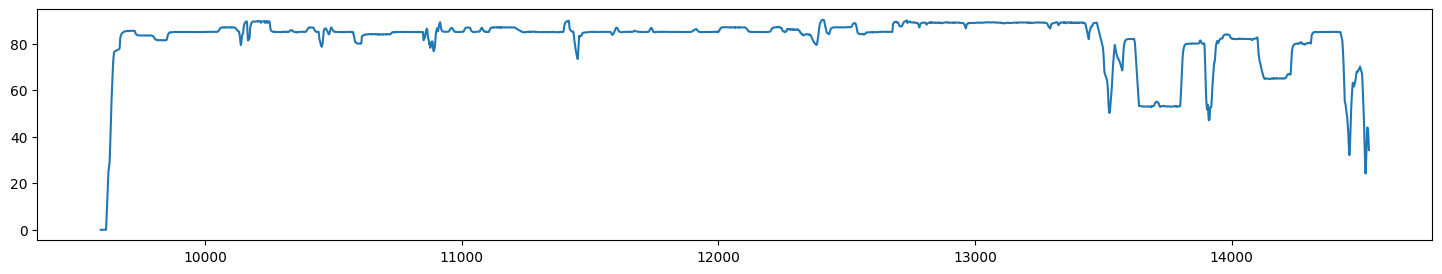

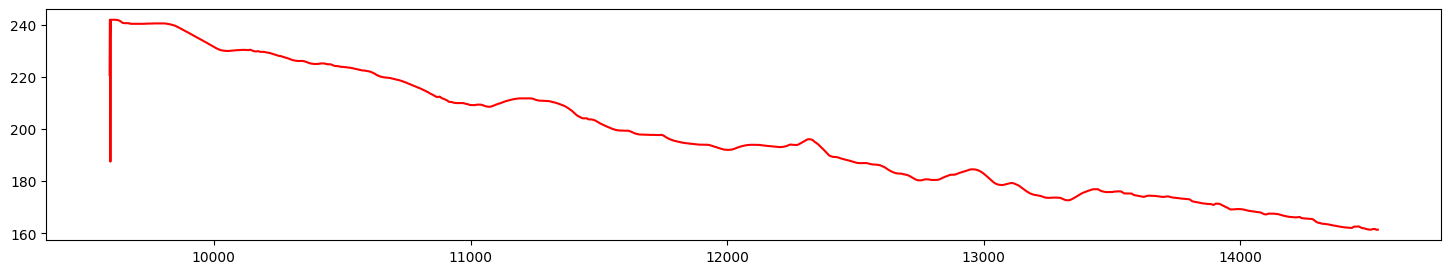

5957
0.0


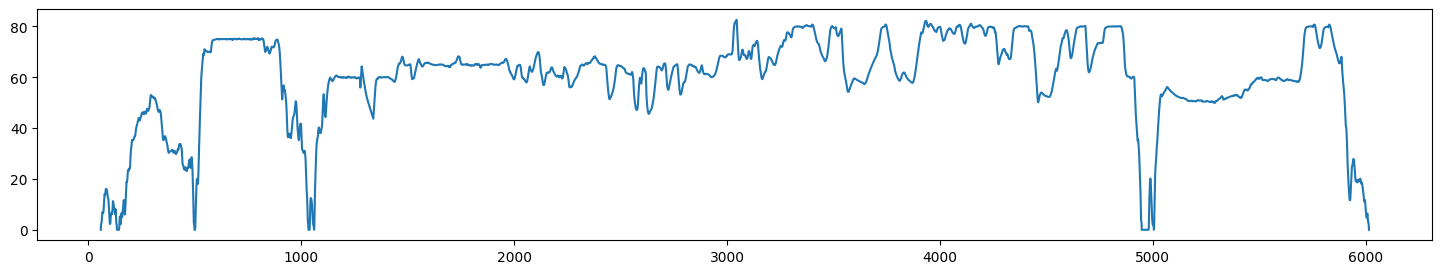

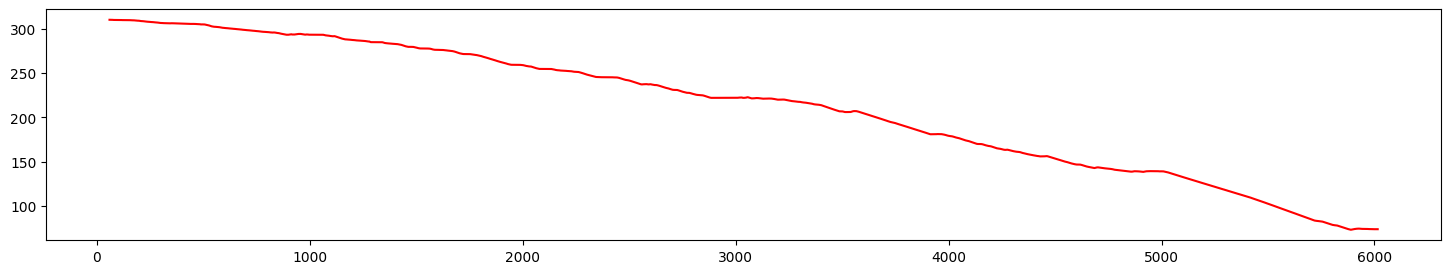

9615
0.0


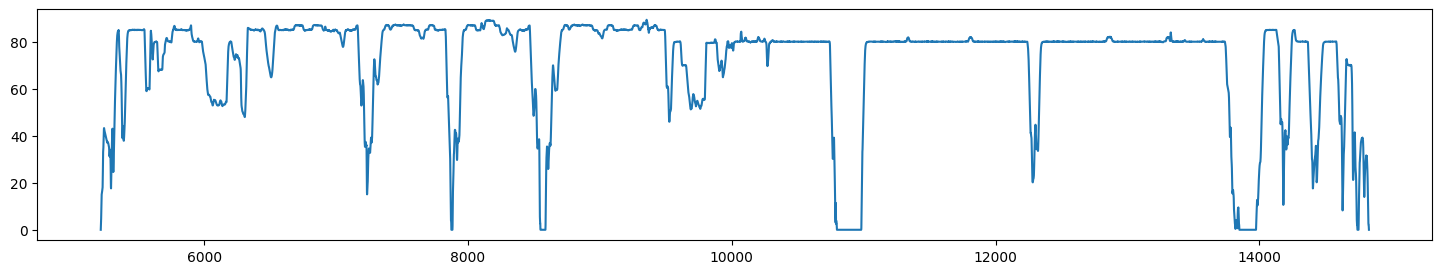

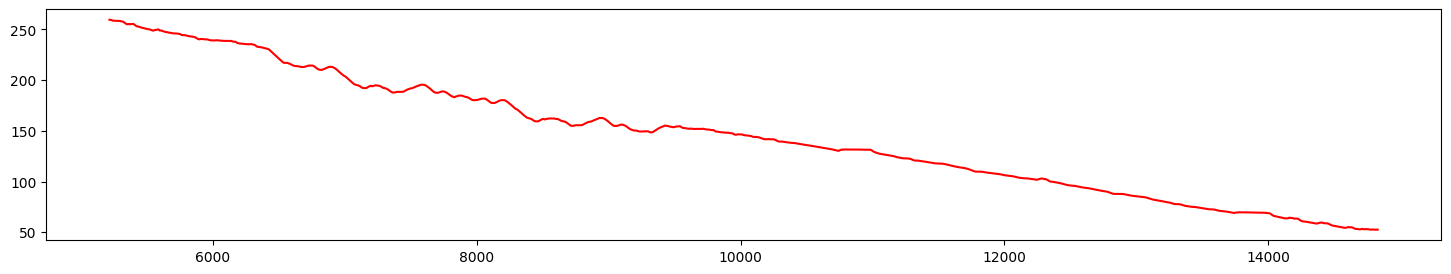

1081
0.0


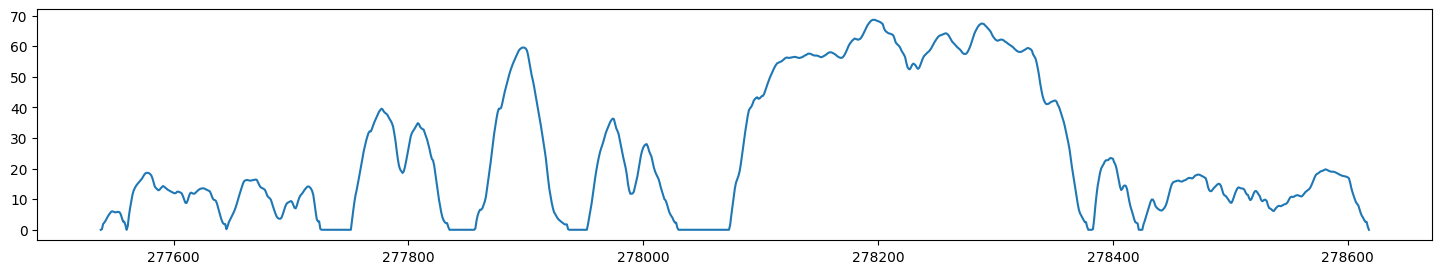

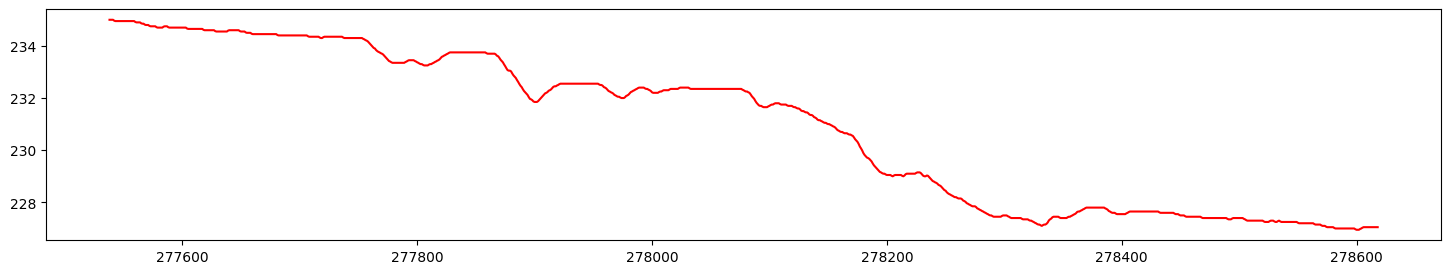

9739
0.0


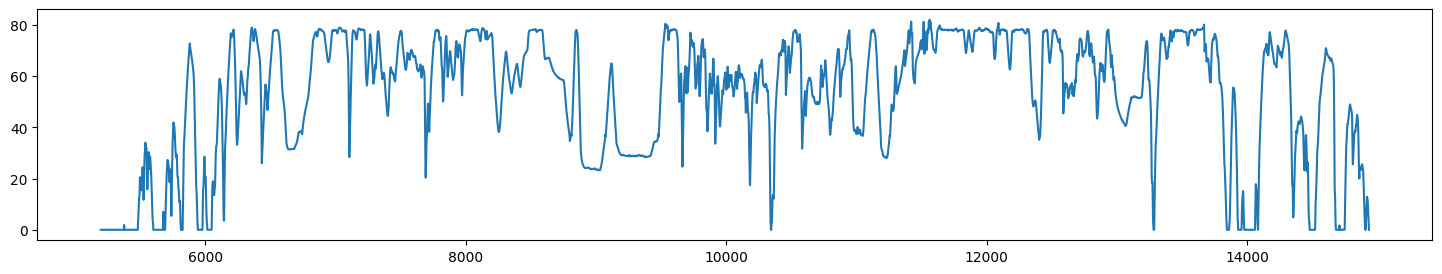

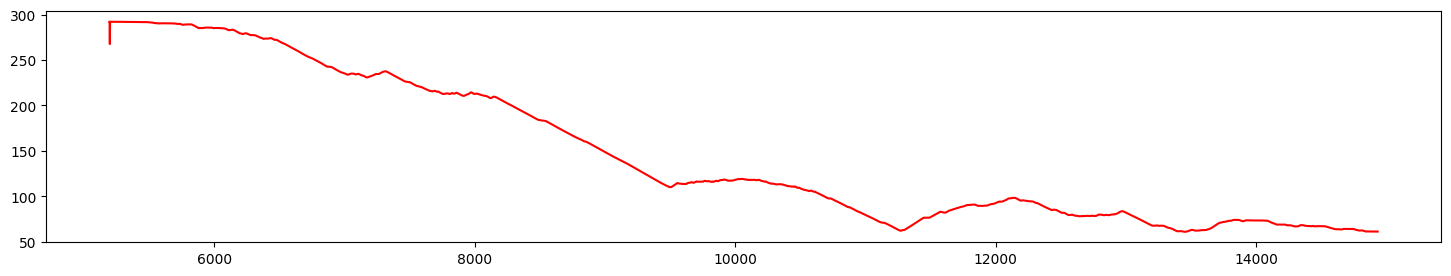

802
0.0


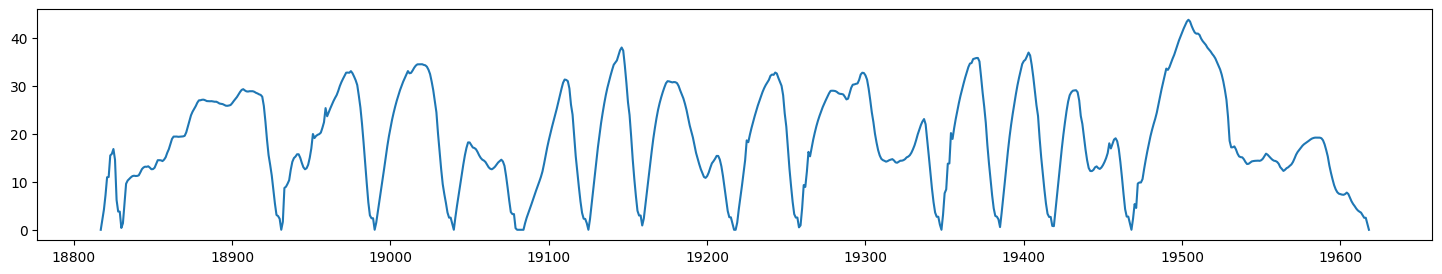

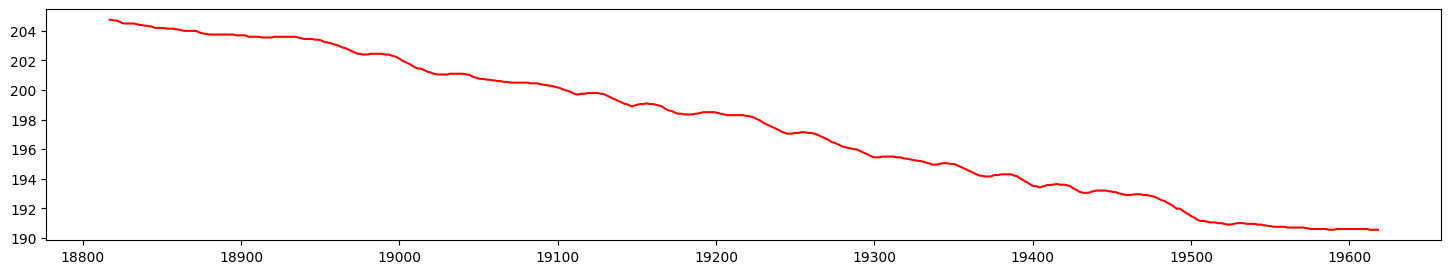

148
0.0


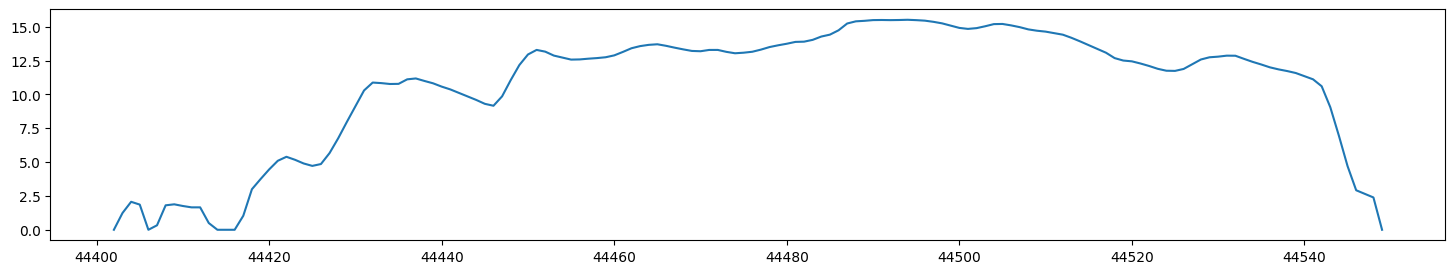

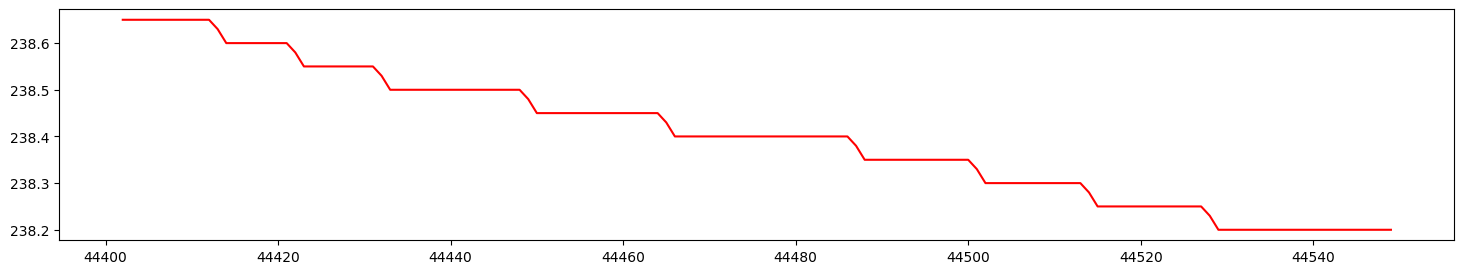

989
0.0


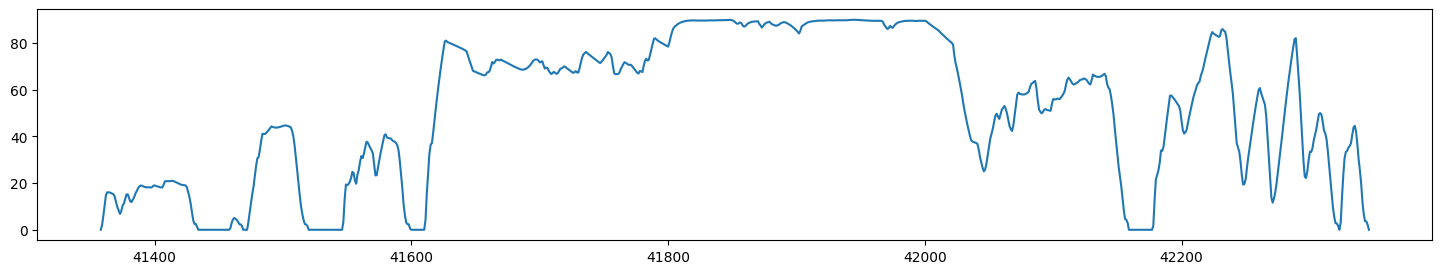

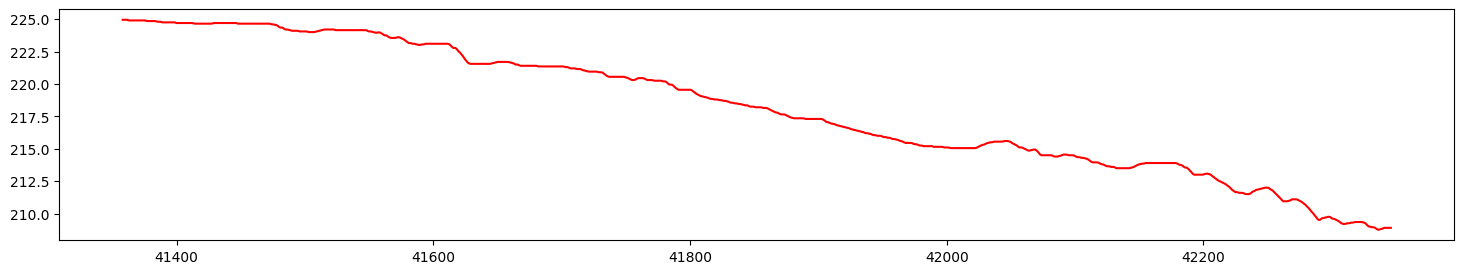

1324
0.0


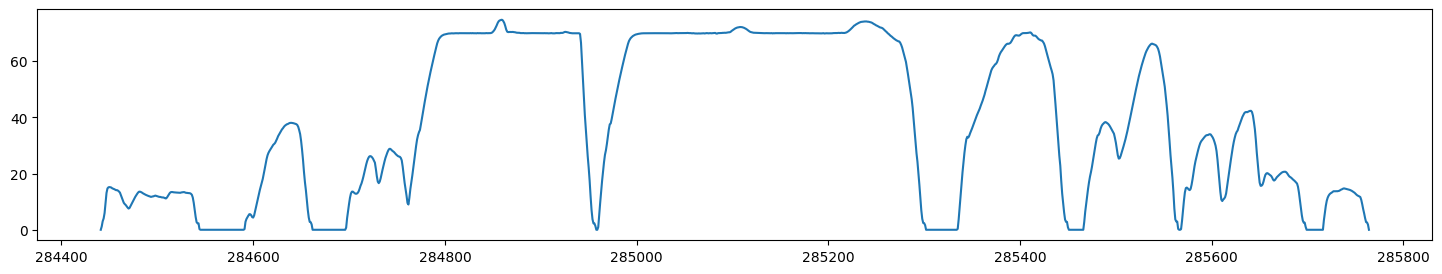

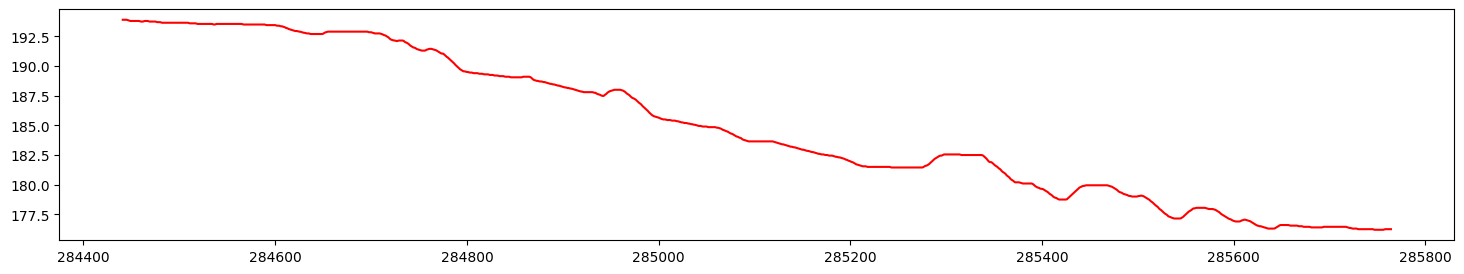

168
0.0


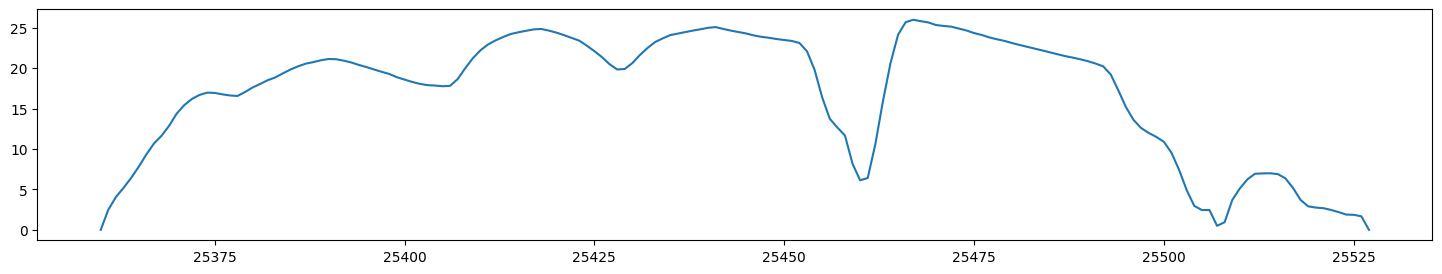

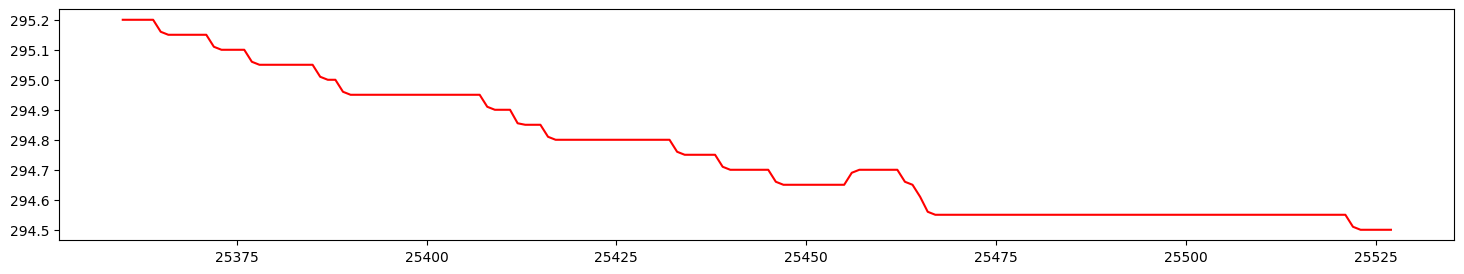

In [15]:
samples = random.sample(trips, 10)
for i in samples:
    file_path = Path(all_trips_folder, i)
    df = pd.read_parquet(file_path, engine='fastparquet')
    print(len(df))

    v = df["vehspd_cval_cpc"]
    en = df["hv_batmomavldischrgen_cval_1"]
    #en = df["hv_batmomavldischrgen_cval_1"].ffill().bfill()
    #en = df["hv_batmomavldischrgen_cval_1"].interpolate(method='spline', order=3)
    #en = df["hv_batmomavldischrgen_cval_1"].interpolate(method='polynomial', order=2)
    print(df["hv_batmomavldischrgen_cval_1"].isna().mean())


    v.plot(subplots=True, figsize=(18, 3))
    plt.show()
    en.plot(subplots=True, figsize=(18, 3), color ='r'); plt.show()
    #df["hv_batmomavldischrgen_cval_1"].plot(subplots=True, figsize=(18, 3), color ='r')
    #df["altitude_cval_ippc"].plot(subplots=True, figsize=(18, 3), color ='g')
    #df["bs_roadincln_cval"].plot(subplots=True, figsize=(18, 3), color ='g')
    plt.show()


In [16]:
# PREPROCESSING #########################################################
#########################################################################
# loop through every file:
for n, f in enumerate(trips):
    print(f"Reading File: {f}, {n+1}/{len(trips)}")
    # get file info
    vehicle_id = f[1:4].strip("_TV."); file_code = f[:9].strip(".parquet")

    # read to dataframe
    df = pd.read_parquet(Path(all_trips_folder, f), engine='fastparquet')
    df.sort_index(axis=1, inplace=True)
    # drop sparse signals
    df.drop(columns = drop_signals, inplace=True)

    # correct timestamp if necessary:
    if max(df.signal_time).year < 2000:
        df.signal_time = pd.to_datetime(df.signal_ts * (10**3))

    signal_only_nans = list(df.columns[np.array(df.isnull().all())])
    signal_with_nans = list(df.columns[np.array(df.isnull().any())])
    constants = {}

    # concatenate signal pairs
    for pair in pair_signals:
        df[pair[0]] = df[[pair[0],pair[1]]].mean(axis=1, skipna=True)
        df.drop(columns=[pair[1]], inplace=True)

    # fill optional signals apporpriately
    for sig in signal_only_nans:
        if sig in optional_or_zero:
            df[sig] = 0
        elif sig in optional_or_one:
            df[sig] = 1

    for sig in df.columns:
        # extract constant values if available:
        if len({x for x in df[sig] if x==x}) == 1:      # number of distinct non-NaN-values
            constants[sig] = df[sig].iloc[df[sig].first_valid_index()] 

        # Filtering, smoothing and outlier removal:
        if sig in signal_remove_outliers:
            df[sig], _, _ = smooth_filter(df[sig], 60, remove_outliers = True, smooth = False)
        elif sig in signal_with_nans and df[sig].nunique() > 1:    
            df[sig], _, _ = smooth_filter(df[sig], 60, remove_outliers = False, smooth = False)
        else:
            df[sig] = df[sig].fillna(df[sig].mean())
    
    print(df)

    # check again for nans and fill only columns with nans:
    columns_with_nans = df.columns[df.isna().any()].tolist()
    if columns_with_nans:
        df[columns_with_nans] = df[columns_with_nans].ffill().bfill()
    
    # check if there are still any nans:
    if df.isna().any().any():
        print(f"Warning: There are still NaN values in the dataframe for file {f}, columns_with_nans: {columns_with_nans}")


    # RESAMPLING: --> separate directory
    ###############################################
    df_resampled = df.resample('10s', on = 'signal_time').mean() # RESAMPLE AT 10 seconds intervals
    df_resampled.reset_index(inplace=True)

    # as the resampling leads to NaN values, that have to be corrected once again:
    # check again for nans and fill only columns with nans:
    columns_with_nans = df_resampled.columns[df_resampled.isna().any()].tolist()
    if columns_with_nans:
        df_resampled[columns_with_nans] = df_resampled[columns_with_nans].ffill().bfill()

    # check if there are still any nans:
    if df_resampled.isna().any().any():
        print(f"Warning: There are still NaN values in the dataframe (resampled) for file {f}, columns_with_nans: {columns_with_nans}")

    break
    # COLLECTED TIME SERIES DATA 
    ############################################################################################
    if True:
        # TIME:
        ###############################################
        time = pd.DataFrame(np.array((df.signal_time - df.signal_time[0]).dt.seconds))    # TIME since trip Start [s] --> corresponding to time series indices
        time_unix = df.signal_time  # UNIX TIME (starting 1970) [s]

        # VEHICLE MOTION:
        ###############################################
        dist = ((df.hirestotalvehdist_cval_icuc - df.hirestotalvehdist_cval_icuc.iloc[0]) * 1000).round(3)   # MILEAGE since trip Start [m]
        speed = df.vehspd_cval_cpc/3.6                                  # VEHICLE SPEED [m/s]
        accel = pd.DataFrame(np.diff(speed, prepend = speed.iloc[0]))        # LONGITUDINAL VEHICLE ACCELERATION [m/s^2] 

        # ROUTE: 
        ###############################################
        gps_pos = pd.DataFrame(tuple(zip(df['latitude_cval_ippc'], df['longitude_cval_ippc'])))  
        alt = df.altitude_cval_ippc                                           # ALTITUDE [m]  
        road_grad = pd.DataFrame(df.bs_roadincln_cval)                        # ROAD GRADIENT [%] = [tan(alpha) * 100]   
        amb_temp = pd.DataFrame(savgol_filter(df.airtempoutsd_cval_cpc, 100, 3))    # ambient temperature [°C] [smoothed]

        # BATTERY:
        ###############################################
        soc = df.hv_bat_soc_cval_bms1/100                  # Battery State of Charge [-]
        if "hv_bat_soh_cval_bms1" in constants.keys():
            soh = constants["hv_bat_soh_cval_bms1"]/100
        else:
            soh = np.mean(df.hv_bat_soh_cval_bms1)/100          # Battery State of Health [-] (constant) 
        bat_pwr = df.hv_batpwr_cval_bms1                # Battery Power [kW]  = df.hv_bat_dc_momvolt_cval_bms1  *  df.hv_batcurr_cval_bms1  = U*I
        bat_mom_en = df.hv_batmomavldischrgen_cval_1    # Momentary Available discharge energy [kWh]
        bat_cap_total = np.mean(bat_mom_en + df.hv_batmomavlchrgen_cval_bms1)  # Total battery capacity (constant) [kWh]
        # calculated by mean of sum of momentary available charge and discharge energies

        # MOTOR:
        ###############################################
        mot_1_speed = df.actualspeed_pti1               # Motor 1 Speed [rpm]
        mot_1_torque = df.actualtorque_pti1             # Motor 1 Torque [Nm] (or [%] ?)
        mot_2_speed = df.actualspeed_pti1               # Motor 2 Speed [rpm]
        mot_2_torque = df.actualtorque_pti1             # Motor 2 Torque [Nm] (or [%] ?)
        mot_pwr = df.emot_pwr_cval                      # Electrical power of motors (combined) [kW]

        # VEHICLE:
        ###############################################
        V = CreateVehicle(vehicle_id)        # import vehicle parameters
        vehweight = df.vehweight_cval_pt*1000  # weight (t) (PT) [kg]
        grocmb = df.grocmbvehweight_cval       # gross combination weight (t) [kg]
        try:
            weight_est_mean = sum(np.multiply(grocmb,dist))/sum(dist)       # approximated vehicle weight [kg]
        # if 'grocombvehweight' is empty:
        except:
            weight_est_mean = np.mean(vehweight)
            
        # COLLECTED TIME SERIES DATA 
        ############################################################################################
        T = pd.concat([time, time_unix, dist, speed, accel, gps_pos, alt, road_grad, amb_temp,soc,bat_pwr,bat_mom_en, 
                    mot_1_speed,mot_1_torque,mot_2_speed,mot_2_torque,mot_pwr, vehweight, grocmb], axis = 1)

        T.columns = ['t',                      # Time since Trip Start ,[s]
                    'date',                    # Date-time stamp
                    'dist',                    # Distance since Start, [m]
                    'speed',                   # Speed, [m/s]
                    'accel',                   # Acceleration, [m/s²]
                    'lat','long',              # GPS-Coordinates (Latitude, Longitude)
                    'alt',                     # Altitude, [m]
                    'road_grad',               # Road Slope, [%]
                    'amb_temp',                # Ambient Air Temperature, [°C]
                    'soc',                     # Battery SOC, [-]
                    'bat_pwr',                 # Battery Power, [kW]
                    'bat_mom_en',              # Momentary Available discharge energy [kWh]
                    'Mot1_speed',              # Motor 1 Speed, [rpm]
                    'Mot1_torque',             # Motor 1 Torque, [Nm]
                    'Mot2_speed',              # Motor 2 Speed, [rpm]
                    'Mot1_torque',             # Motor 2 Torque, [Nm]
                    'Mot_pwr',                 # Total Motor Power, [kW]
                    'vehweight',               # Vehicle Weight (PT), [kg]
                    'grocmb'                   # Vehicle Weight (GroCmb), [kg]
                    ]      

        # PARAMETERS EXTRACTED FROM DATA 
        ############################################################################################
        C = {}
        C = dict((k,eval(k)) for k in ["weight_est_mean","soh","bat_cap_total"])
        C = {**C,**constants}         

        # Save as pickle file in destination folder
        ############################################################################################
        with open(f'{trips_processed_pickles}/{prefix + file_code}.pickle', 'wb') as handle:
            pickle.dump([T,C,V.prm], handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save new dataframes
    ############################################################################################
    df.drop(columns = ['hv_batmomavlchrgen_cval_bms1', 'hv_bat_soh_cval_bms1'], inplace=True)
    df.to_parquet(f'{trips_processed_final}/{prefix + file_code}.parquet')
    df_resampled.drop(columns = ['hv_batmomavlchrgen_cval_bms1', 'hv_bat_soh_cval_bms1'], inplace=True)
    df_resampled.to_parquet(f'{trips_processed_resampled}/{prefix + file_code}.parquet')
    print(f'{prefix + file_code} saved')


Reading File: V101_T1.parquet, 1/16823


KeyError: '[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23\n 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47\n 48 49 50] not in index'

In [17]:
df

,accelpdlposn_cval,actdrvtrnpwrprc_cval,actualdcvoltage_pti1,actualspeed_pti1,actualtorque_pti1,airtempinsd_cval_hvac,airtempinsd_rq,airtempoutsd_cval_cpc,altitude_cval_ippc,brc_stat_brc1,...,powerstagetemperature_pti1,pt4_dcb_hvdc_power_max_st3,rmsmotorcurrent_pti1,roadgrad_cval_pt,selgr_rq_pt,signal_time,signal_ts,txoiltemp_cval_tcm,vehspd_cval_cpc,vehweight_cval_pt
51,7.16,3.27,443.865,-347.25,-2.959961,24.093750,21.0,21.375000,-17.000,1.0,...,24.0,55.0,23.8975,0.00,1.0,2022-08-31 04:53:21.451001088,1.661922e+18,23.318750,0.000000,14.0
52,6.72,3.29,443.850,-507.10,-2.864845,24.093750,21.0,21.375000,-17.000,1.0,...,24.0,55.0,24.1975,0.00,1.0,2022-08-31 04:53:22.451000832,1.661922e+18,23.375000,1.548047,14.0
53,1.36,0.68,443.900,-583.00,-0.600030,24.093750,21.0,21.400000,-17.000,1.0,...,24.0,55.0,5.1575,0.00,1.0,2022-08-31 04:53:23.451001088,1.661922e+18,23.375000,2.235937,14.0
54,0.00,0.00,443.915,-562.20,-0.002772,24.093750,21.0,21.500000,-17.000,1.0,...,24.0,55.0,0.4175,0.36,1.0,2022-08-31 04:53:24.451000832,1.661922e+18,23.375000,2.317969,14.0
55,0.00,0.00,443.925,-748.20,-0.002772,24.093750,21.0,21.475000,-17.000,1.0,...,24.0,55.0,0.4375,1.48,1.0,2022-08-31 04:53:25.451001088,1.661922e+18,23.375000,2.533594,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7202,0.00,-75.10,422.105,905.45,0.131211,22.365625,21.0,14.187500,764.625,1.0,...,46.0,55.0,11.6350,-0.48,1.0,2022-08-31 06:52:32.450999808,1.661929e+18,48.093750,5.045703,14.0
7203,0.00,-37.55,422.170,97.90,-0.019178,22.290625,21.0,14.196875,764.625,1.0,...,46.0,55.0,0.3700,-0.72,1.0,2022-08-31 06:52:33.451000064,1.661929e+18,48.103125,3.161719,14.0
7204,0.00,0.00,422.140,-1.85,-0.000428,22.281250,21.0,14.281250,764.625,1.0,...,46.0,55.0,0.2900,-0.80,1.0,2022-08-31 06:52:34.450999808,1.661929e+18,48.206250,3.121094,14.0
7205,0.00,0.00,422.150,-0.45,-0.002772,22.365625,21.0,14.281250,764.625,1.0,...,46.0,55.0,0.2625,0.48,1.0,2022-08-31 06:52:35.451000064,1.661929e+18,48.387500,1.560547,14.0


In [ ]:
df = pd.read_parquet(Path(parquet_folder, 'v_id983V101_trip100.parquet'), engine='fastparquet')
columns_with_nans = df.columns[df.isna().all()].tolist()
print(f"file v_id983V101_trip100.parquet, columns_with_nans: {columns_with_nans}")

In [ ]:
columns_selection = ["signal_time", 
            "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "bs_roadincln_cval", "ambtemp_cval_pt", "hv_batpwr_cval_bms1", 
            "hv_batmomavldischrgen_cval_1"]

In [ ]:
df

In [ ]:
all_columns

In [ ]:
list(all_columns)

In [ ]:
# plot multiple random time series signals from random files
import matplotlib.pyplot as plt
import random

for sig in ["hv_batmaxdischrgpwrlim_cval"]:
    samples = random.sample(trips, 10)
    for f in samples:
        df = pd.read_parquet(Path(parquet_folder, f), engine='fastparquet')
        _ = df[sig].plot(figsize=(18, 2), subplots=True, title=sig)
       # _ = pd.DataFrame(df["chargestate"]*100).plot(figsize=(18, 5), subplots=True, color='r')
       # _ = df["hv_chrgpwr_ecpc_cval"].plot(figsize=(18, 5), subplots=True, title="hv_chrgpwr_ecpc_cval")
        plt.show()

In [ ]:
def check_nans_in_parquet_files(directories):
    files_with_nans = []

    for directory in directories:
        for file in directory.glob("*.parquet"):
            df = pd.read_parquet(file, engine='fastparquet')
            if df.isna().any().any():
                nan_columns = df.columns[df.isna().any()].tolist()
                files_with_nans.append((file, nan_columns))
                print(f"File {file} has NaNs in columns: {nan_columns}")

    return files_with_nans

directories = [Path(DATA_PATH, "final_2", "trips_processed_resampled"), Path(DATA_PATH, "final_2", "trips_processed_final")]
files_with_nans = check_nans_in_parquet_files(directories)

print("Files with NaNs:")
for file in files_with_nans:
    print(file)

In [ ]:
total_values_count = 0
trips = get_files(trips_processed_final, ".parquet", full=True)

for trip_file in trips:
    metadata = pq.read_metadata(Path(parquet_folder, trip_file))
    total_values_count += metadata.num_rows * metadata.num_columns

print(f"Total number of values in all trip files: {total_values_count}")
print(f"Average file length: {round(total_values_count / (len(trips) * metadata.num_columns))}")



In [ ]:

for trip_file in trips:
    df = pd.read_parquet(Path(parquet_folder, trip_file), engine='fastparquet')

    total_values_count += df.size

print(f"Total number of values in all trip files: {total_values_count}")

In [ ]:
import os

base_names = [os.path.basename(file[0]) for file in files_with_nans]
print(base_names)
[f for f in base_names if f not in remove_selection]


In [ ]:
df.info()


In [ ]:
%%skip
def get_non_empty_columns(parquet_folder):
    # Initialize a set with all column names from the first file
    first_file = next(parquet_folder.glob("*.parquet"))
    df = pd.read_parquet(first_file, engine='fastparquet')
    non_empty_columns = set(df.columns)

    # Iterate through each file and update the set of non-empty columns
    for file in parquet_folder.glob("*.parquet"):
        df = pd.read_parquet(file, engine='fastparquet')
        non_empty_columns &= set(df.columns[df.notna().any()])

    return list(non_empty_columns)

non_empty_columns = get_non_empty_columns(parquet_folder)
print("Columns that are never empty in any file:")


In [ ]:
# empty_columns = [col for col in all_columns if col not in non_empty_columns and col not in sparse_signals]
empty_columns = ['cc_setspd_cval', 'minmoduletempindex_bms01', 'brc_stat_brc2', 'maxbrickvoltage_bms01', 'maxpwr_contendrnbrkresist2', 
'chargestate', 'actualtorque_pti2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval', 'hv_batisores_cval_e2e', 'emot_pwr_cval', 'dsrdpwr_contendrn_cval', 
'grocmbvehweight_cval', 'actualtorque_pti1', 'brc_stat_brc1', 'pt4_dcb_hvdc_power_max_st3', 'hv_pwr_cval_dcl1', 'airtempoutsd_cval_cpc', 
'actdrvtrnpwrprc_cval', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_ptc_cabin1_pwr_cval', 'lv_conv_voltdmd_e2e_dcl1', 
'lv_convmaxcurr_cval_dcl1', 'hv_batlinkvoltage_sc01', 'hv_dclink_volt_cval_brc2', 'maxmoduletempindex_bms01', 'elcomp_pwrcons_cval', 
'lv_convcurr_cval_dcl1', 'oiltemp_ra_cval', 'pt4_dcb_temp1_st3', 'pt4_dcb_temp2_st3', 'hv_curr_cval_dcl1', 'hv_dclink_volt_cval_dcl1', 
'lv_conv_dc_momvolt_cval_dcl1', 'maxrecuppwrprc_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'lv_convpwr_cval_dcl1', 
'epto_pwr_cval', 'maxtracpwrpct_cval', 'currtmp_brkresist1int_cval', 'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 
'maxpwr_contendrnbrkresist_cval', 'hv_bat_intres_cval_bms1', 'stringvoltage_bms01', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']


In [ ]:
%%skip
def find_files_with_all_nans(parquet_folder, empty_columns):
    result = {column: {"count": 0, "files": []} for column in empty_columns}
    
    for file in parquet_folder.glob("*.parquet"):
        print(file)
        df = pd.read_parquet(file, engine='fastparquet', columns=empty_columns)
        
        for column in empty_columns:
            if df[column].isna().all():
                result[column]["count"] += 1
                result[column]["files"].append(file.name)
    
    return result

nan_columns_files = find_files_with_all_nans(parquet_folder, empty_columns)

for column, info in nan_columns_files.items():
    print(f"Column: {column}")
    print(f"Number of files with all NaNs: {info['count']}")
    print(f"Files: {info['files']}\n")


In [ ]:
%%skip
collected_files = set()
collected_signals = []

for column, info in nan_columns_files.items():
    if info['count'] < 140:
        for file_name in info['files']:
            collected_files.add(file_name)
    else:
        collected_signals.append(column)

collected_files =[x for x in collected_files if x not in short_trips]
print(f"Collected parquet files: {len(collected_files)}")
for file in collected_files:
    print(file)

print(f"Collected signals: {len(collected_signals)}")
for signal in collected_signals:
    print(signal)

In [ ]:
# Results:
remove_selection = ['v_id983V2_trip5.parquet', 'v_id983V10_trip60.parquet', 'v_id983V2_trip19.parquet', 'v_id983V13_trip2.parquet', 
'v_id983V13_trip276_2.parquet', 'v_id983V14_trip2.parquet', 'v_id983V16_trip185.parquet', 'v_id983V11_trip15.parquet', 
'v_id983V10_trip27.parquet', 'v_id983V10_trip48.parquet', 'v_id983V1_trip8.parquet', 'v_id983V10_trip21.parquet', 'v_id983V16_trip304.parquet', 
'v_id983V2_trip37.parquet', 'v_id983V1_trip16.parquet', 'v_id983V1_trip16_2.parquet', 'v_id983V10_trip57.parquet', 'v_id983V16_trip190.parquet',
'v_id983V10_trip29_2.parquet', 'v_id983V16_trip197_2.parquet', 'v_id983V10_trip39.parquet', 'v_id983V10_trip49.parquet', 'v_id983V101_trip54.parquet', 
'v_id983V1_trip2_2.parquet', 'v_id983V10_trip4.parquet', 'v_id983V17_trip46.parquet', 'v_id983V101_trip175.parquet', 'v_id983V10_trip39_2.parquet',
'v_id983V11_trip16.parquet', 'v_id983V2_trip44.parquet', 'v_id983V10_trip61.parquet', 'v_id983V10_trip54.parquet', 'v_id983V16_trip188_2.parquet',
'v_id983V10_trip35.parquet', 'v_id983V10_trip16.parquet', 'v_id983V17_trip69.parquet', 'v_id983V17_trip1.parquet', 'v_id983V10_trip38.parquet', 
'v_id983V1_trip1.parquet', 'v_id983V10_trip52_2.parquet', 'v_id983V1_trip7.parquet', 'v_id983V10_trip23.parquet', 'v_id983V11_trip16_2.parquet',
'v_id983V16_trip184.parquet', 'v_id983V2_trip21.parquet', 'v_id983V2_trip15.parquet', 'v_id983V10_trip47.parquet', 'v_id983V2_trip12.parquet', 
'v_id983V2_trip3_2.parquet', 'v_id983V16_trip180.parquet', 'v_id983V2_trip25.parquet', 'v_id983V2_trip7.parquet', 'v_id983V16_trip179.parquet',
'v_id983V2_trip27.parquet', 'v_id983V2_trip13.parquet', 'v_id983V2_trip3.parquet', 'v_id983V17_trip70.parquet', 'v_id983V11_trip13_2.parquet',
'v_id983V1_trip9_2.parquet', 'v_id983V10_trip26_2.parquet', 'v_id983V10_trip24.parquet', 'v_id983V10_trip29.parquet', 'v_id983V2_trip17.parquet',
'v_id983V10_trip55.parquet', 'v_id983V10_trip14.parquet', 'v_id983V16_trip178.parquet', 'v_id983V10_trip58.parquet', 'v_id983V2_trip39.parquet',
'v_id983V16_trip183.parquet', 'v_id983V10_trip37.parquet', 'v_id983V10_trip5.parquet', 'v_id983V10_trip20_2.parquet', 'v_id983V2_trip32.parquet',
'v_id983V16_trip188.parquet', 'v_id983V2_trip36.parquet', 'v_id983V10_trip25.parquet', 'v_id983V2_trip30.parquet', 'v_id983V11_trip14_2.parquet',
'v_id983V2_trip20.parquet', 'v_id983V2_trip38.parquet', 'v_id983V16_trip184_2.parquet', 'v_id983V1_trip11.parquet', 'v_id983V10_trip55_2.parquet',
'v_id983V10_trip5_2.parquet', 'v_id983V10_trip37_2.parquet', 'v_id983V2_trip39_2.parquet', 'v_id983V10_trip3.parquet',
'v_id983V10_trip60_2.parquet', 'v_id983V10_trip2.parquet', 'v_id983V2_trip16.parquet', 'v_id983V2_trip24.parquet', 'v_id983V2_trip18.parquet', 
'v_id983V10_trip59.parquet', 'v_id983V16_trip182.parquet', 'v_id983V1_trip6_2.parquet', 'v_id983V10_trip42.parquet', 'v_id983V2_trip44_2.parquet',
'v_id983V10_trip18.parquet', 'v_id983V17_trip2.parquet', 'v_id983V16_trip3.parquet', 'v_id983V2_trip36_2.parquet', 'v_id983V10_trip10.parquet', 
'v_id983V16_trip192.parquet', 'v_id983V2_trip35.parquet', 'v_id983V13_trip5.parquet', 'v_id983V2_trip10.parquet', 'v_id983V1_trip9.parquet', 
'v_id983V10_trip6.parquet', 'v_id983V10_trip44.parquet', 'v_id983V19_trip2_2.parquet', 'v_id983V16_trip186.parquet', 'v_id983V10_trip15.parquet',
'v_id983V19_trip4.parquet', 'v_id983V11_trip13.parquet', 'v_id983V16_trip196.parquet', 'v_id983V2_trip33.parquet', 'v_id983V16_trip191.parquet',
'v_id983V1_trip2.parquet', 'v_id983V10_trip41.parquet', 'v_id983V16_trip193.parquet', 'v_id983V2_trip11.parquet', 'v_id983V17_trip5.parquet',
'v_id983V10_trip17.parquet', 'v_id983V1_trip15.parquet', 'v_id983V10_trip9.parquet', 'v_id983V2_trip4.parquet', 'v_id983V10_trip42_2.parquet',
'v_id983V10_trip52.parquet', 'v_id983V4_trip86.parquet', 'v_id983V10_trip40.parquet', 'v_id983V10_trip28.parquet',
'v_id983V10_trip14_2.parquet', 'v_id983V2_trip23.parquet', 'v_id983V16_trip181.parquet', 'v_id983V1_trip4.parquet', 
'v_id983V10_trip7.parquet', 'v_id983V1_trip34.parquet', 'v_id983V19_trip1.parquet', 'v_id983V2_trip34.parquet', 'v_id983V10_trip43.parquet',
'v_id983V16_trip187.parquet', 'v_id983V17_trip4.parquet', 'v_id983V13_trip276.parquet', 'v_id983V10_trip26.parquet', 
'v_id983V16_trip180_2.parquet', 'v_id983V16_trip195.parquet', 'v_id983V11_trip14.parquet', 'v_id983V16_trip197.parquet',
'v_id983V13_trip1.parquet', 'v_id983V1_trip12.parquet', 'v_id983V10_trip56.parquet', 'v_id983V10_trip59_2.parquet',
'v_id983V2_trip8.parquet', 'v_id983V2_trip1.parquet', 'v_id983V2_trip22_2.parquet', 'v_id983V1_trip10.parquet', 'v_id983V2_trip42.parquet', 
'v_id983V2_trip15_2.parquet', 'v_id983V10_trip57_2.parquet', 'v_id983V10_trip49_2.parquet', 'v_id983V10_trip8.parquet',
'v_id983V10_trip50.parquet', 'v_id983V4_trip79.parquet', 'v_id983V16_trip194.parquet', 'v_id983V2_trip2.parquet',
'v_id983V10_trip13_2.parquet', 'v_id983V13_trip4.parquet', 'v_id983V17_trip6.parquet', 'v_id983V2_trip24_2.parquet', 
'v_id983V2_trip9.parquet', 'v_id983V16_trip185_2.parquet', 'v_id983V10_trip13.parquet', 'v_id983V2_trip14.parquet', 
'v_id983V2_trip22.parquet', 'v_id983V19_trip2.parquet', 'v_id983V2_trip6.parquet']

collected_signals = ['brc_stat_brc2', 'maxpwr_contendrnbrkresist2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval',
'dsrdpwr_contendrn_cval', 'brc_stat_brc1', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_dclink_volt_cval_brc2',
'oiltemp_ra_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'epto_pwr_cval', 'currtmp_brkresist1int_cval', 
'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 'maxpwr_contendrnbrkresist_cval', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']
len(remove_selection), len(collected_signals)

In [ ]:
def check_all_nan_columns(parquet_folder, remove_selection):
    files_with_all_nan_columns = []

    for file_name in remove_selection:
        file_path = Path(parquet_folder, file_name)
        df = pd.read_parquet(file_path, engine='fastparquet')
        columns_to_check = [col for col in df.columns if col not in drop_signals]
        all_nan_columns = df[columns_to_check].columns[df[columns_to_check].isna().all()].tolist()
        
        if all_nan_columns:
            files_with_all_nan_columns.append((file_name, all_nan_columns))
            print(f"File {file_name} has all-NaN columns: {all_nan_columns}")

    return files_with_all_nan_columns

files_with_all_nan_columns = check_all_nan_columns(parquet_folder, trips)

In [ ]:
def find_files_with_all_nans(parquet_folder, empty_columns):
    result = {column: {"count": 0, "files": []} for column in empty_columns}
    
    for file in parquet_folder.glob("*.parquet"):
        df = pd.read_parquet(file, engine='fastparquet', columns=empty_columns)
        
        for column in empty_columns:
            if df[column].isna().any() and df[column].isna().all():
                result[column]["count"] += 1
                result[column]["files"].append(file.name)
    
    return result

nan_columns_files = find_files_with_all_nans(parquet_folder, ['hv_bat_dc_volt_cval_bms1'])

for column, info in nan_columns_files.items():
    print(f"Column: {column}")
    print(f"Number of files with all NaNs: {info['count']}")
    print(f"Files: {info['files']}\n")

In [ ]:
collected_signals = ['brc_stat_brc2', 'maxpwr_contendrnbrkresist2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval',
    'dsrdpwr_contendrn_cval', 'brc_stat_brc1', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_dclink_volt_cval_brc2',
    'oiltemp_ra_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'epto_pwr_cval', 'currtmp_brkresist1int_cval', 
    'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 'maxpwr_contendrnbrkresist_cval', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']

In [ ]:
empty_columns = ['cc_setspd_cval', 'minmoduletempindex_bms01', 'brc_stat_brc2', 'maxbrickvoltage_bms01', 'maxpwr_contendrnbrkresist2', 
'chargestate', 'actualtorque_pti2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval', 'hv_batisores_cval_e2e', 'emot_pwr_cval', 'dsrdpwr_contendrn_cval', 
'grocmbvehweight_cval', 'actualtorque_pti1', 'brc_stat_brc1', 'pt4_dcb_hvdc_power_max_st3', 'hv_pwr_cval_dcl1', 'airtempoutsd_cval_cpc', 
'actdrvtrnpwrprc_cval', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_ptc_cabin1_pwr_cval', 'lv_conv_voltdmd_e2e_dcl1', 
'lv_convmaxcurr_cval_dcl1', 'hv_batlinkvoltage_sc01', 'hv_dclink_volt_cval_brc2', 'maxmoduletempindex_bms01', 'elcomp_pwrcons_cval', 
'lv_convcurr_cval_dcl1', 'oiltemp_ra_cval', 'pt4_dcb_temp1_st3', 'pt4_dcb_temp2_st3', 'hv_curr_cval_dcl1', 'hv_dclink_volt_cval_dcl1', 
'lv_conv_dc_momvolt_cval_dcl1', 'maxrecuppwrprc_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'lv_convpwr_cval_dcl1', 
'epto_pwr_cval', 'maxtracpwrpct_cval', 'currtmp_brkresist1int_cval', 'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 
'maxpwr_contendrnbrkresist_cval', 'hv_bat_intres_cval_bms1', 'stringvoltage_bms01', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']

In [ ]:
# signals more important than missing trips
required = ["cc_setspd_cval", "maxbrickvoltage_bms01", "actualtorque_pti1", "actualtorque_pti2", "hv_batisores_cval_e2e", "emot_pwr_cval", "grocmbvehweight_cval", "pt4_dcb_hvdc_power_max_st3",
            "pt4_dcb_temp1_st3", "pt4_dcb_temp2_st3", "hv_pwr_cval_dcl1", "airtempoutsd_cval_cpc", "actdrvtrnpwrprc_cval", "hv_ptc_cabin1_pwr_cval", "elcomp_pwrcons_cval",
            "hv_curr_cval_dcl1", "hv_dclink_volt_cval_dcl1", "maxrecuppwrprc_cval", 'lv_convpwr_cval_dcl1', 'maxtracpwrpct_cval', 'hv_bat_dc_volt_cval_bms1']

# trips more important so signals can be removed:
remove = ["minmoduletempindex_bms01", "maxmoduletempindex_bms01", "brc_stat_brc2", "maxpwr_contendrnbrkresist2","currtmp_brkresist2int_cval", "currpwr_contendrnbrkresist2",
 "chargestate", "dsrdpwr_contendrn2_cval","maproadgrad_cval", "airtempoutsd_cval_sca", "meanmoduletemperature_bms01", "linkvoltage_bms05", "lv_conv_voltdmd_e2e_dcl1",
  "lv_convmaxcurr_cval_dcl1", "lv_convcurr_cval_dcl1","lv_conv_dc_momvolt_cval_dcl1", "hv_batlinkvoltage_sc01", "hv_dclink_volt_cval_brc", "hv_dclink_volt_cval_brc2",
   "oiltemp_ra_cval", "hv_ptc2_pwr_cval","hv_bat_intres_cval_bms1", "stringvoltage_bms01", "currtmp_brkresist1int_cval", "maxpwr_contendrnbrkresist_cval"]

in_question = ["hv_bat_dc_momvolt_cval_bms1"]

In [ ]:
sample = random.choice(trips)
#sample = 'v_id983V10_trip13_2.parquet'
print(sample)
df = pd.read_parquet(Path(DATA_PATH, "processed", sample), engine='fastparquet')
_ = df["airtempoutsd_cval_cpc"].plot(figsize=(18, 4), subplots=True, color='r')
_ = df['ambtemp_cval_pt'].plot(figsize=(18, 3), subplots=True, color='g')
_ = pd.DataFrame(df["hv_curr_cval_dcl1"]).plot(figsize=(18, 3), subplots=True, color='b')

_ = pd.DataFrame(df["airtempoutsd_cval_cpc"] - df["airtempoutsd_cval_sca"]).plot(figsize=(18, 3), subplots=True)
#print((df['lv_conv_dc_momvolt_cval_dcl1'] * df['lv_convcurr_cval_dcl1'] * 1e-3).mean())
print((df["hv_bat_intres_cval_bms1"]).mean())

In [ ]:
df["hv_bat_dc_momvolt_cval_bms1"].isna().all()

In [ ]:
sample = random.choice(info['files'])
df = pd.read_parquet(Path(DATA_PATH, "processed", sample), engine='fastparquet')
#_ = df['actdrvtrnpwrprc_cval'].plot(figsize=(18, 4), subplots=True, color='r')
_ = df['epto_pwr_cval'].plot(figsize=(18, 4), subplots=True)

In [ ]:
collected_files = set()
collected_signals = []

for column, info in nan_columns_files.items():
    if info['count'] < 140:
        for file_name in info['files']:
            collected_files.add(file_name)
    else:
        collected_signals.append(column)

collected_files =[x for x in collected_files if x not in short_trips]
print(f"Collected parquet files: {len(collected_files)}")
for file in collected_files:
    print(file)

print(f"Collected signals: {len(collected_signals)}")
for signal in collected_signals:
    print(signal)

In [ ]:
# Extract mean velocity from each file
mean_velocities = []
dist = []
for file in files:
    df = pd.read_parquet(file, columns = ['vehspd_cval_cpc',"hirestotalvehdist_cval_icuc"], engine='fastparquet')
    mean_velocity = df['vehspd_cval_cpc'].mean()
    d_dist = df["hirestotalvehdist_cval_icuc"].max() - df["hirestotalvehdist_cval_icuc"].min()
    dist.append(d_dist)
    mean_velocities.append(mean_velocity)

# Plot histogram
plt.figure(figsize=(12, 4))
plt.hist(dist, bins=30, edgecolor='black')
plt.xlabel('Driven Distance')
plt.ylabel('Count')
plt.title('Histogram of Distances')
plt.grid(True)
plt.show()


dist = [d for d in dist if d <= 1000]
plt.figure(figsize=(12, 4))
plt.hist(dist, bins=30, edgecolor='black')
plt.xlabel('Driven Distance [km]')
plt.ylabel('Count')
plt.title('Histogram of Distances')
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase tick numbers size
plt.show()